<h1 style="text-align:center"> Development of Credit Risk Model For XYZ Finance </h1>

XYZ Finance, a Non-Banking Financial Company (NBFC) based in India, ask to develop a sophisticated credit risk model. 
This model will include a credit scorecard that categorizes loan applications into Poor, Average, Good, and Excellent categories, 
based on criteria similar to the CIBIL scoring system.

# Import Library

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler
import math



# Set style
sns.set_style("whitegrid")
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_columns', None)

# Data Collection

## Import Dataset

In [2]:
bureau_df = pd.read_csv("./dataset/bureau_data.csv")
customer_df = pd.read_csv("./dataset/customers.csv")
loans_df = pd.read_csv("./dataset/loans.csv")

In [3]:
bureau_df.head(2)

,cust_id,number_of_open_accounts,number_of_closed_accounts,total_loan_months,delinquent_months,total_dpd,enquiry_count,credit_utilization_ratio
0,C00001,1,1,42,0,0,3,7
1,C00002,3,1,96,12,60,5,4


In [4]:
bureau_df.shape

(50000, 8)

In [5]:
customer_df.head(2)

,cust_id,age,gender,marital_status,employment_status,income,number_of_dependants,residence_type,years_at_current_address,city,state,zipcode
0,C00001,44,M,Married,Self-Employed,2586000,3,Owned,27,Delhi,Delhi,110001
1,C00002,38,M,Married,Salaried,1206000,3,Owned,4,Chennai,Tamil Nadu,600001


In [6]:
customer_df.shape

(50000, 12)

In [7]:
loans_df.head(2)

,loan_id,cust_id,loan_purpose,loan_type,sanction_amount,loan_amount,processing_fee,gst,net_disbursement,loan_tenure_months,principal_outstanding,bank_balance_at_application,disbursal_date,installment_start_dt,default
0,L00001,C00001,Auto,Secured,3004000,2467000,49340.00,444060,1973600,33,1630408,873386,2019-07-24,2019-08-10,False
1,L00002,C00002,Home,Secured,4161000,3883000,77660.00,698940,3106400,30,709309,464100,2019-07-24,2019-08-15,False


In [8]:
loans_df.shape

(50000, 15)

## Merge 3 Dataset in one

In [9]:
crm_df_merged = pd.merge(customer_df, bureau_df, how='inner', on='cust_id')

In [10]:
crm_df = pd.merge(crm_df_merged, loans_df, how='inner', on='cust_id')
crm_df.head()

,cust_id,age,gender,marital_status,employment_status,income,number_of_dependants,residence_type,years_at_current_address,city,state,zipcode,number_of_open_accounts,number_of_closed_accounts,total_loan_months,delinquent_months,total_dpd,enquiry_count,credit_utilization_ratio,loan_id,loan_purpose,loan_type,sanction_amount,loan_amount,processing_fee,gst,net_disbursement,loan_tenure_months,principal_outstanding,bank_balance_at_application,disbursal_date,installment_start_dt,default
0,C00001,44,M,Married,Self-Employed,2586000,3,Owned,27,Delhi,Delhi,110001,1,1,42,0,0,3,7,L00001,Auto,Secured,3004000,2467000,49340.00,444060,1973600,33,1630408,873386,2019-07-24,2019-08-10,False
1,C00002,38,M,Married,Salaried,1206000,3,Owned,4,Chennai,Tamil Nadu,600001,3,1,96,12,60,5,4,L00002,Home,Secured,4161000,3883000,77660.00,698940,3106400,30,709309,464100,2019-07-24,2019-08-15,False
2,C00003,46,F,Married,Self-Employed,2878000,3,Owned,24,Kolkata,West Bengal,700001,2,1,82,24,147,6,58,L00003,Personal,Unsecured,2401000,2170000,43400.00,390600,1736000,21,1562399,1476042,2019-07-24,2019-08-21,False
3,C00004,55,F,Single,Self-Employed,3547000,1,Owned,15,Bangalore,Karnataka,560001,3,0,115,15,87,5,26,L00004,Personal,Unsecured,2345000,1747000,34940.00,314460,1397600,6,1257839,1031094,2019-07-24,2019-08-09,False
4,C00005,37,M,Married,Salaried,3432000,3,Owned,28,Pune,Maharashtra,411001,4,2,120,0,0,5,10,L00005,Auto,Secured,4647000,4520000,90400.00,813600,3616000,28,1772334,1032458,2019-07-24,2019-08-02,False


### Dimention of Datasets

In [11]:
crm_df.shape

(50000, 33)

### Description about features are

- Loan Details

    Loan Amount: The total sum of money a borrower receives from a lender.

    Loan Purpose: The reason the loan was taken (e.g., home, education, personal, vehicle).

    Loan-to-Income Ratio: A financial metric showing how much of a borrower's income goes toward loan repayments.
        `Formula: (Loan Amount / Annual Income)`

    Net Disbursement: The actual amount credited to the borrower's account after deductions like fees or insurance.

    Sanctioned Amount: The total loan amount approved by the lender (may be higher than what’s disbursed).

    Days Past Due (DPD): The number of days a payment is overdue from its due date.

- Bureau Data (Credit Report Info)

    Number of Open Accounts: Active credit lines (e.g., loans or credit cards currently in use).

    Number of Closed Accounts: Credit lines that have been fully paid off and closed.

    Inquiry Count (likely a typo in your list “Inquir, Lount”): The number of times lenders have pulled your credit report, typically during loan or card applications.

    Credit Utilization Ratio: The percentage of available credit you're currently using.
        `Formula: (Current Credit Used / Total Credit Limit) × 100`

    Delinquent Months: Number of months the borrower had at least one payment overdue.

    Months Since Last Delinquency: How many months have passed since the borrower last missed a payment.

### Information about each feature and its datatypes

In [12]:
crm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 33 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   cust_id                      50000 non-null  object 
 1   age                          50000 non-null  int64  
 2   gender                       50000 non-null  object 
 3   marital_status               50000 non-null  object 
 4   employment_status            50000 non-null  object 
 5   income                       50000 non-null  int64  
 6   number_of_dependants         50000 non-null  int64  
 7   residence_type               49938 non-null  object 
 8   years_at_current_address     50000 non-null  int64  
 9   city                         50000 non-null  object 
 10  state                        50000 non-null  object 
 11  zipcode                      50000 non-null  int64  
 12  number_of_open_accounts      50000 non-null  int64  
 13  number_of_closed

In [13]:
crm_df.isna().sum()

cust_id                         0
age                             0
gender                          0
marital_status                  0
employment_status               0
income                          0
number_of_dependants            0
residence_type                 62
years_at_current_address        0
city                            0
state                           0
zipcode                         0
number_of_open_accounts         0
number_of_closed_accounts       0
total_loan_months               0
delinquent_months               0
total_dpd                       0
enquiry_count                   0
credit_utilization_ratio        0
loan_id                         0
loan_purpose                    0
loan_type                       0
sanction_amount                 0
loan_amount                     0
processing_fee                  0
gst                             0
net_disbursement                0
loan_tenure_months              0
principal_outstanding           0
bank_balance_a

In [14]:
crm_df.default.value_counts()

default
False    45703
True      4297
Name: count, dtype: int64

It clearly shows the class imbalance problem. default class `False` has more data than `True` class. Need to be handled. Also, i want to convert its data type from bool to integer.

In [15]:
crm_df.default = crm_df.default.astype(int)
crm_df.default.dtype

dtype('int64')

In [16]:
X = crm_df.drop(columns='default', axis=1)
y = crm_df.default

### Train_test_split the data inorder to prevent from Data leakage

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

In [18]:
train_df.head(2)

,cust_id,age,gender,marital_status,employment_status,income,number_of_dependants,residence_type,years_at_current_address,city,state,zipcode,number_of_open_accounts,number_of_closed_accounts,total_loan_months,delinquent_months,total_dpd,enquiry_count,credit_utilization_ratio,loan_id,loan_purpose,loan_type,sanction_amount,loan_amount,processing_fee,gst,net_disbursement,loan_tenure_months,principal_outstanding,bank_balance_at_application,disbursal_date,installment_start_dt,default
12746,C12747,59,M,Married,Self-Employed,11327000,3,Owned,30,Hyderabad,Telangana,500001,4,2,152,20,118,4,36,L12747,Home,Secured,33121000,23442000,468840.00,4219560,18753600,28,5000000,4820526,2020-10-31,2020-11-11,0
32495,C32496,44,F,Single,Salaried,715000,0,Owned,27,Mumbai,Maharashtra,400001,3,1,160,10,62,5,5,L32496,Education,Secured,1175000,1149000,22980.00,206820,919200,50,467229,216697,2022-10-22,2022-10-27,0


In [19]:
test_df.head(2)

,cust_id,age,gender,marital_status,employment_status,income,number_of_dependants,residence_type,years_at_current_address,city,state,zipcode,number_of_open_accounts,number_of_closed_accounts,total_loan_months,delinquent_months,total_dpd,enquiry_count,credit_utilization_ratio,loan_id,loan_purpose,loan_type,sanction_amount,loan_amount,processing_fee,gst,net_disbursement,loan_tenure_months,principal_outstanding,bank_balance_at_application,disbursal_date,installment_start_dt,default
19205,C19206,36,M,Married,Self-Employed,3728000,3,Owned,24,Jaipur,Rajasthan,302001,2,1,42,0,0,5,98,L19206,Home,Secured,12767000,9890000,197800.00,1780200,7912000,46,1745379,806208,2021-06-24,2021-07-23,0
15514,C15515,43,F,Single,Self-Employed,2493000,0,Owned,23,Delhi,Delhi,110001,4,0,125,0,0,5,32,L15515,Education,Secured,4295000,3087000,61740.00,555660,2469600,18,1675530,1019647,2021-02-09,2021-02-18,0


In [20]:
print("Train Data Dimension", train_df.shape)
print("Test Data Dimension", test_df.shape)


Train Data Dimension (37500, 33)
Test Data Dimension (12500, 33)


## Data Cleaning

### Handle null data


In [21]:
train_df.isna().sum()

cust_id                         0
age                             0
gender                          0
marital_status                  0
employment_status               0
income                          0
number_of_dependants            0
residence_type                 47
years_at_current_address        0
city                            0
state                           0
zipcode                         0
number_of_open_accounts         0
number_of_closed_accounts       0
total_loan_months               0
delinquent_months               0
total_dpd                       0
enquiry_count                   0
credit_utilization_ratio        0
loan_id                         0
loan_purpose                    0
loan_type                       0
sanction_amount                 0
loan_amount                     0
processing_fee                  0
gst                             0
net_disbursement                0
loan_tenure_months              0
principal_outstanding           0
bank_balance_a

In [22]:
train_df.residence_type.unique()

array(['Owned', 'Mortgage', 'Rented', nan], dtype=object)

In [23]:
train_mode_residence = train_df.residence_type.mode()[0]
test_mode_residence = test_df.residence_type.mode()[0]

residence_type feature has 47 rows missing from train dataset and its from nan category. Since it is categorical column will replaced by Mode value.

### Replacing Null value from Train DF

In [24]:
train_df.residence_type = train_df.residence_type.fillna(train_mode_residence)
train_df.residence_type.unique()

array(['Owned', 'Mortgage', 'Rented'], dtype=object)

### Replacing Null value from Test DF

In [25]:
test_df.residence_type = test_df.residence_type.fillna(test_mode_residence)
test_df.residence_type.unique()

array(['Owned', 'Mortgage', 'Rented'], dtype=object)

### Checking for Duplicates in Train DF

In [26]:
train_df.duplicated().sum()

0

### Checking for Duplicates in Test DF

In [27]:
test_df.duplicated().sum()

0

In [28]:
numerical_cols = ['age', 'income', 'number_of_dependants', 'years_at_current_address', 
                'sanction_amount', 'loan_amount', 'processing_fee', 'gst', 'net_disbursement', 
                'loan_tenure_months','principal_outstanding', 'bank_balance_at_application',
                'number_of_open_accounts','number_of_closed_accounts', 'total_loan_months', 'delinquent_months',
                'total_dpd', 'enquiry_count', 'credit_utilization_ratio']

categorical_cols = ['gender', 'marital_status', 'employment_status', 'residence_type', 'city', 
                    'state', 'zipcode', 'loan_purpose', 'loan_type', 'default']

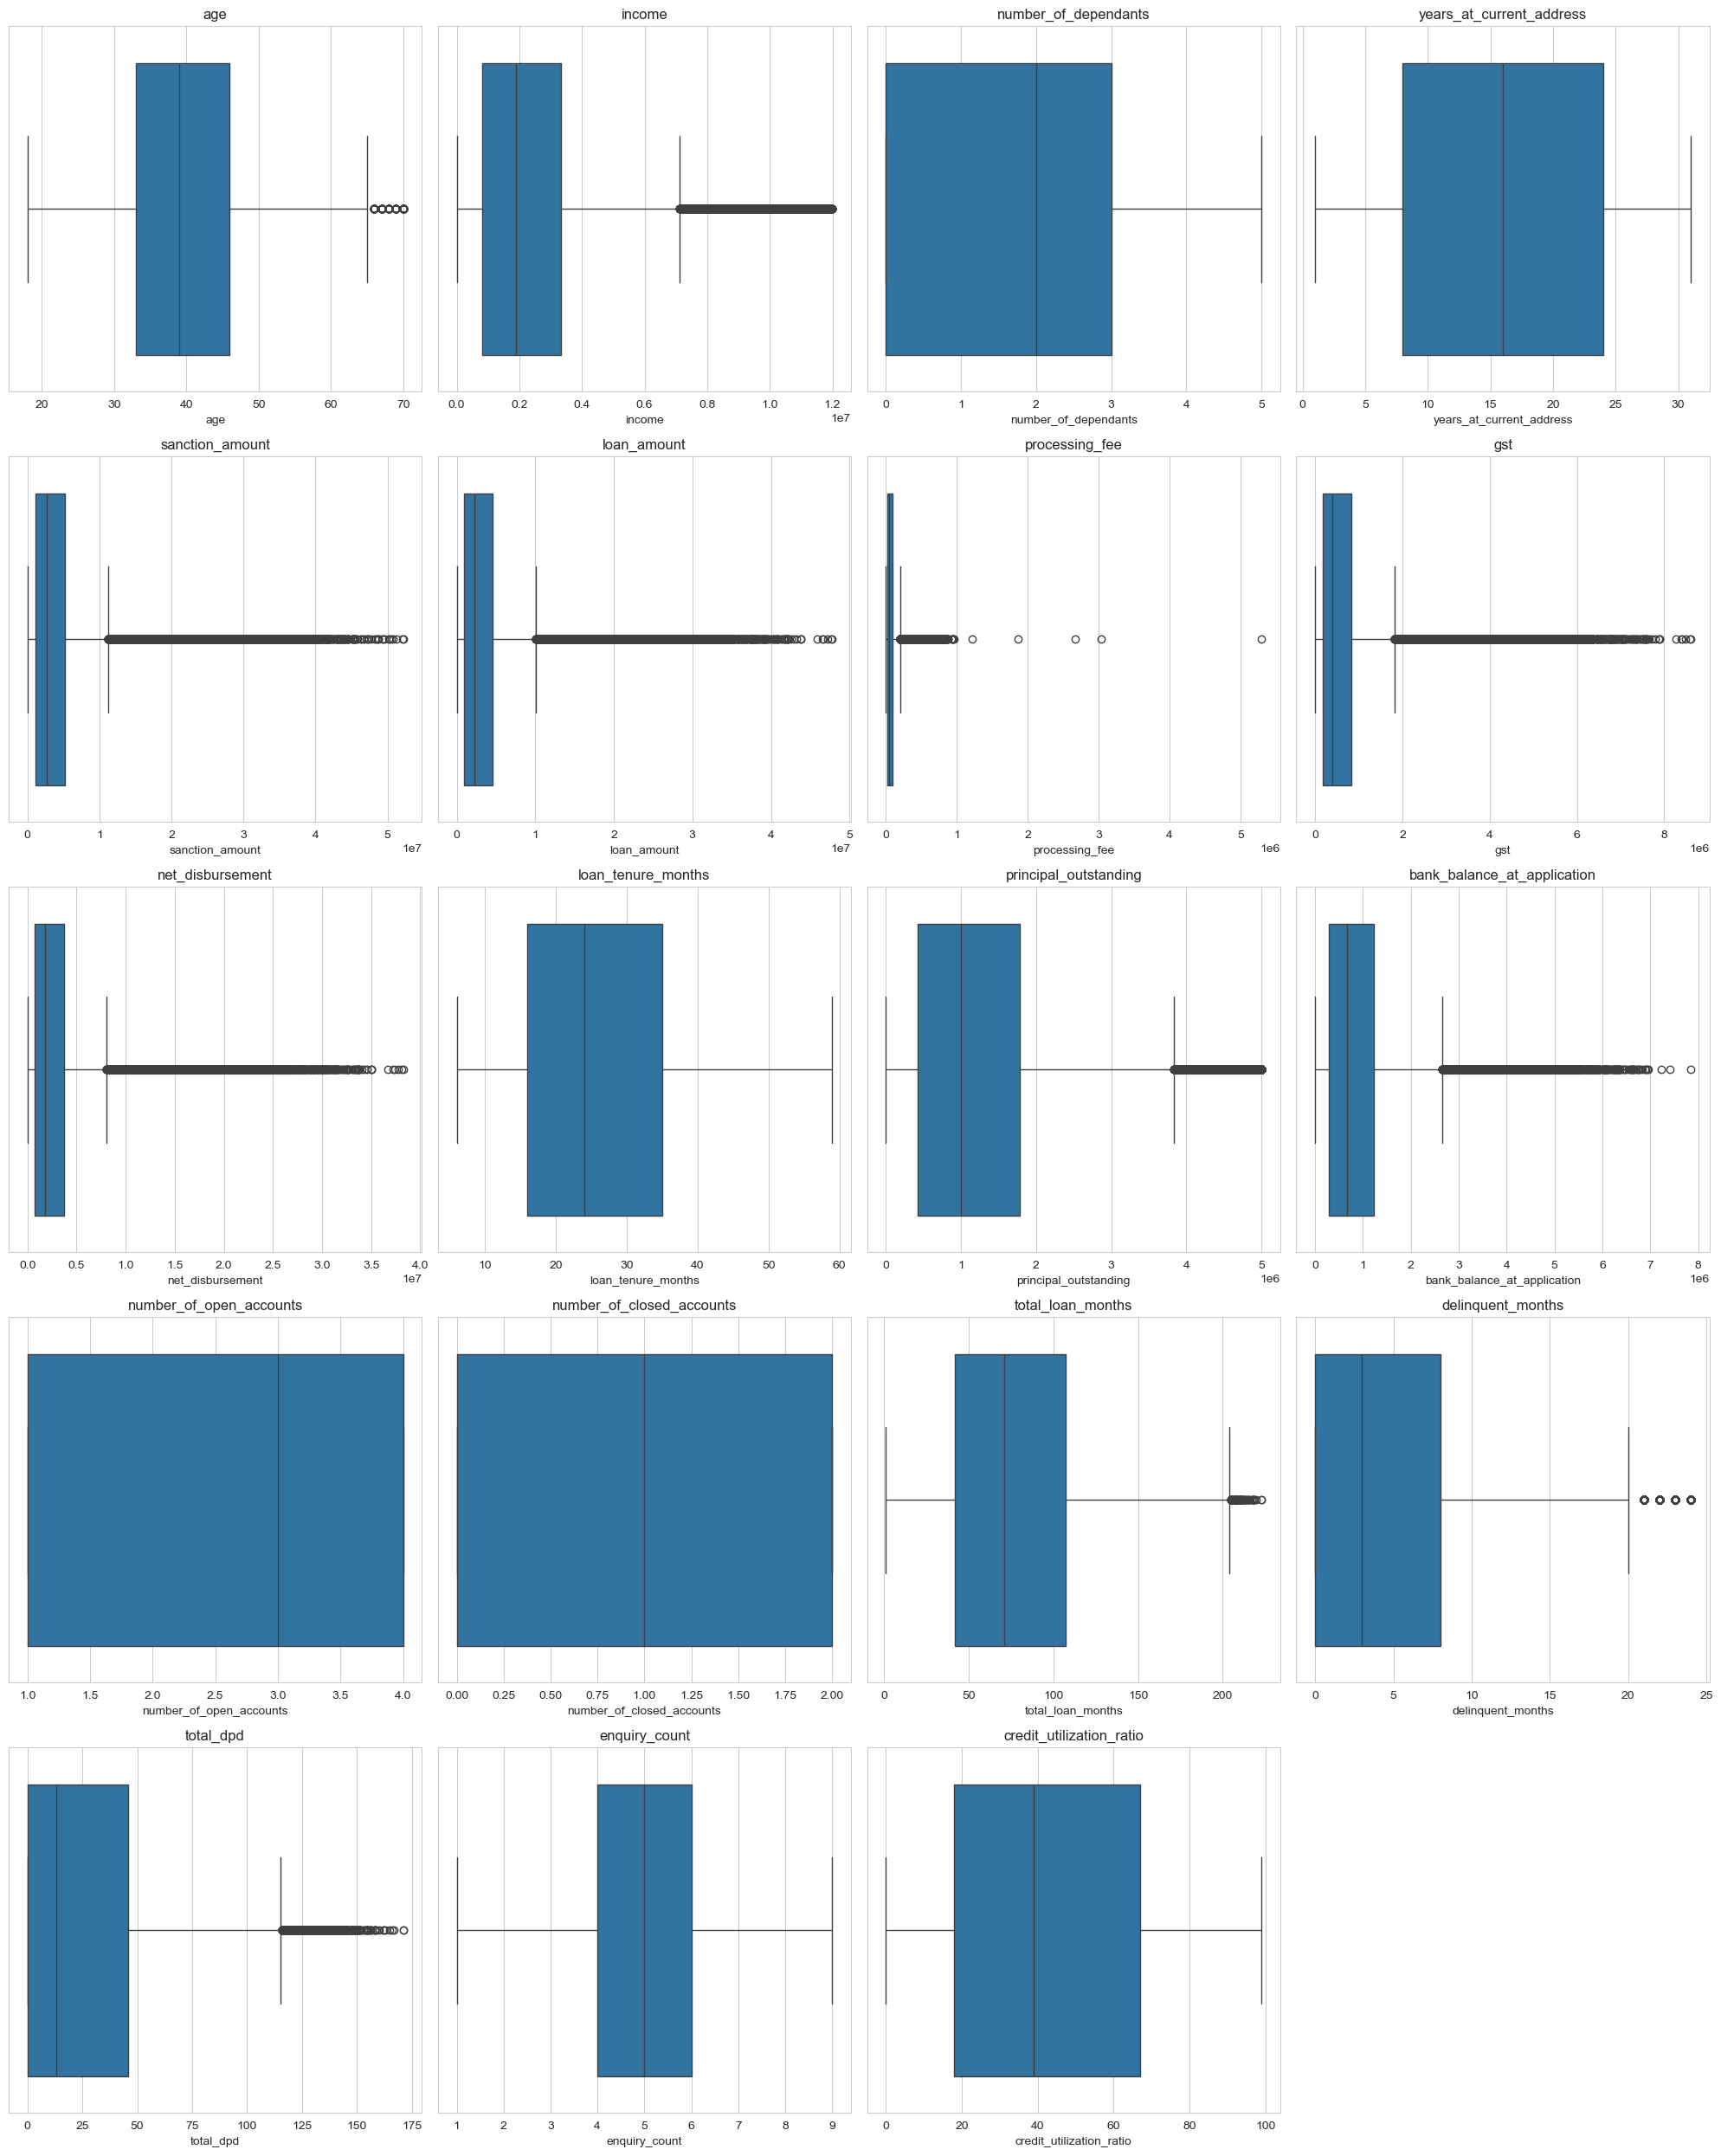

In [29]:
# Grid size (auto-calculated)
num_cols = 4
num_rows = math.ceil(len(numerical_cols) / num_cols) # Calculate the number of rows needed

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows))
axes = axes.flatten()  # Flatten in case of 1D row

# Plot each feature
for i, col in enumerate(numerical_cols):
    ax = axes[i]
    sns.boxplot(x=train_df[col], ax=ax)
    ax.set_title(col) # Set the title to the name of the variable

# Hide unused subplots (if any)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

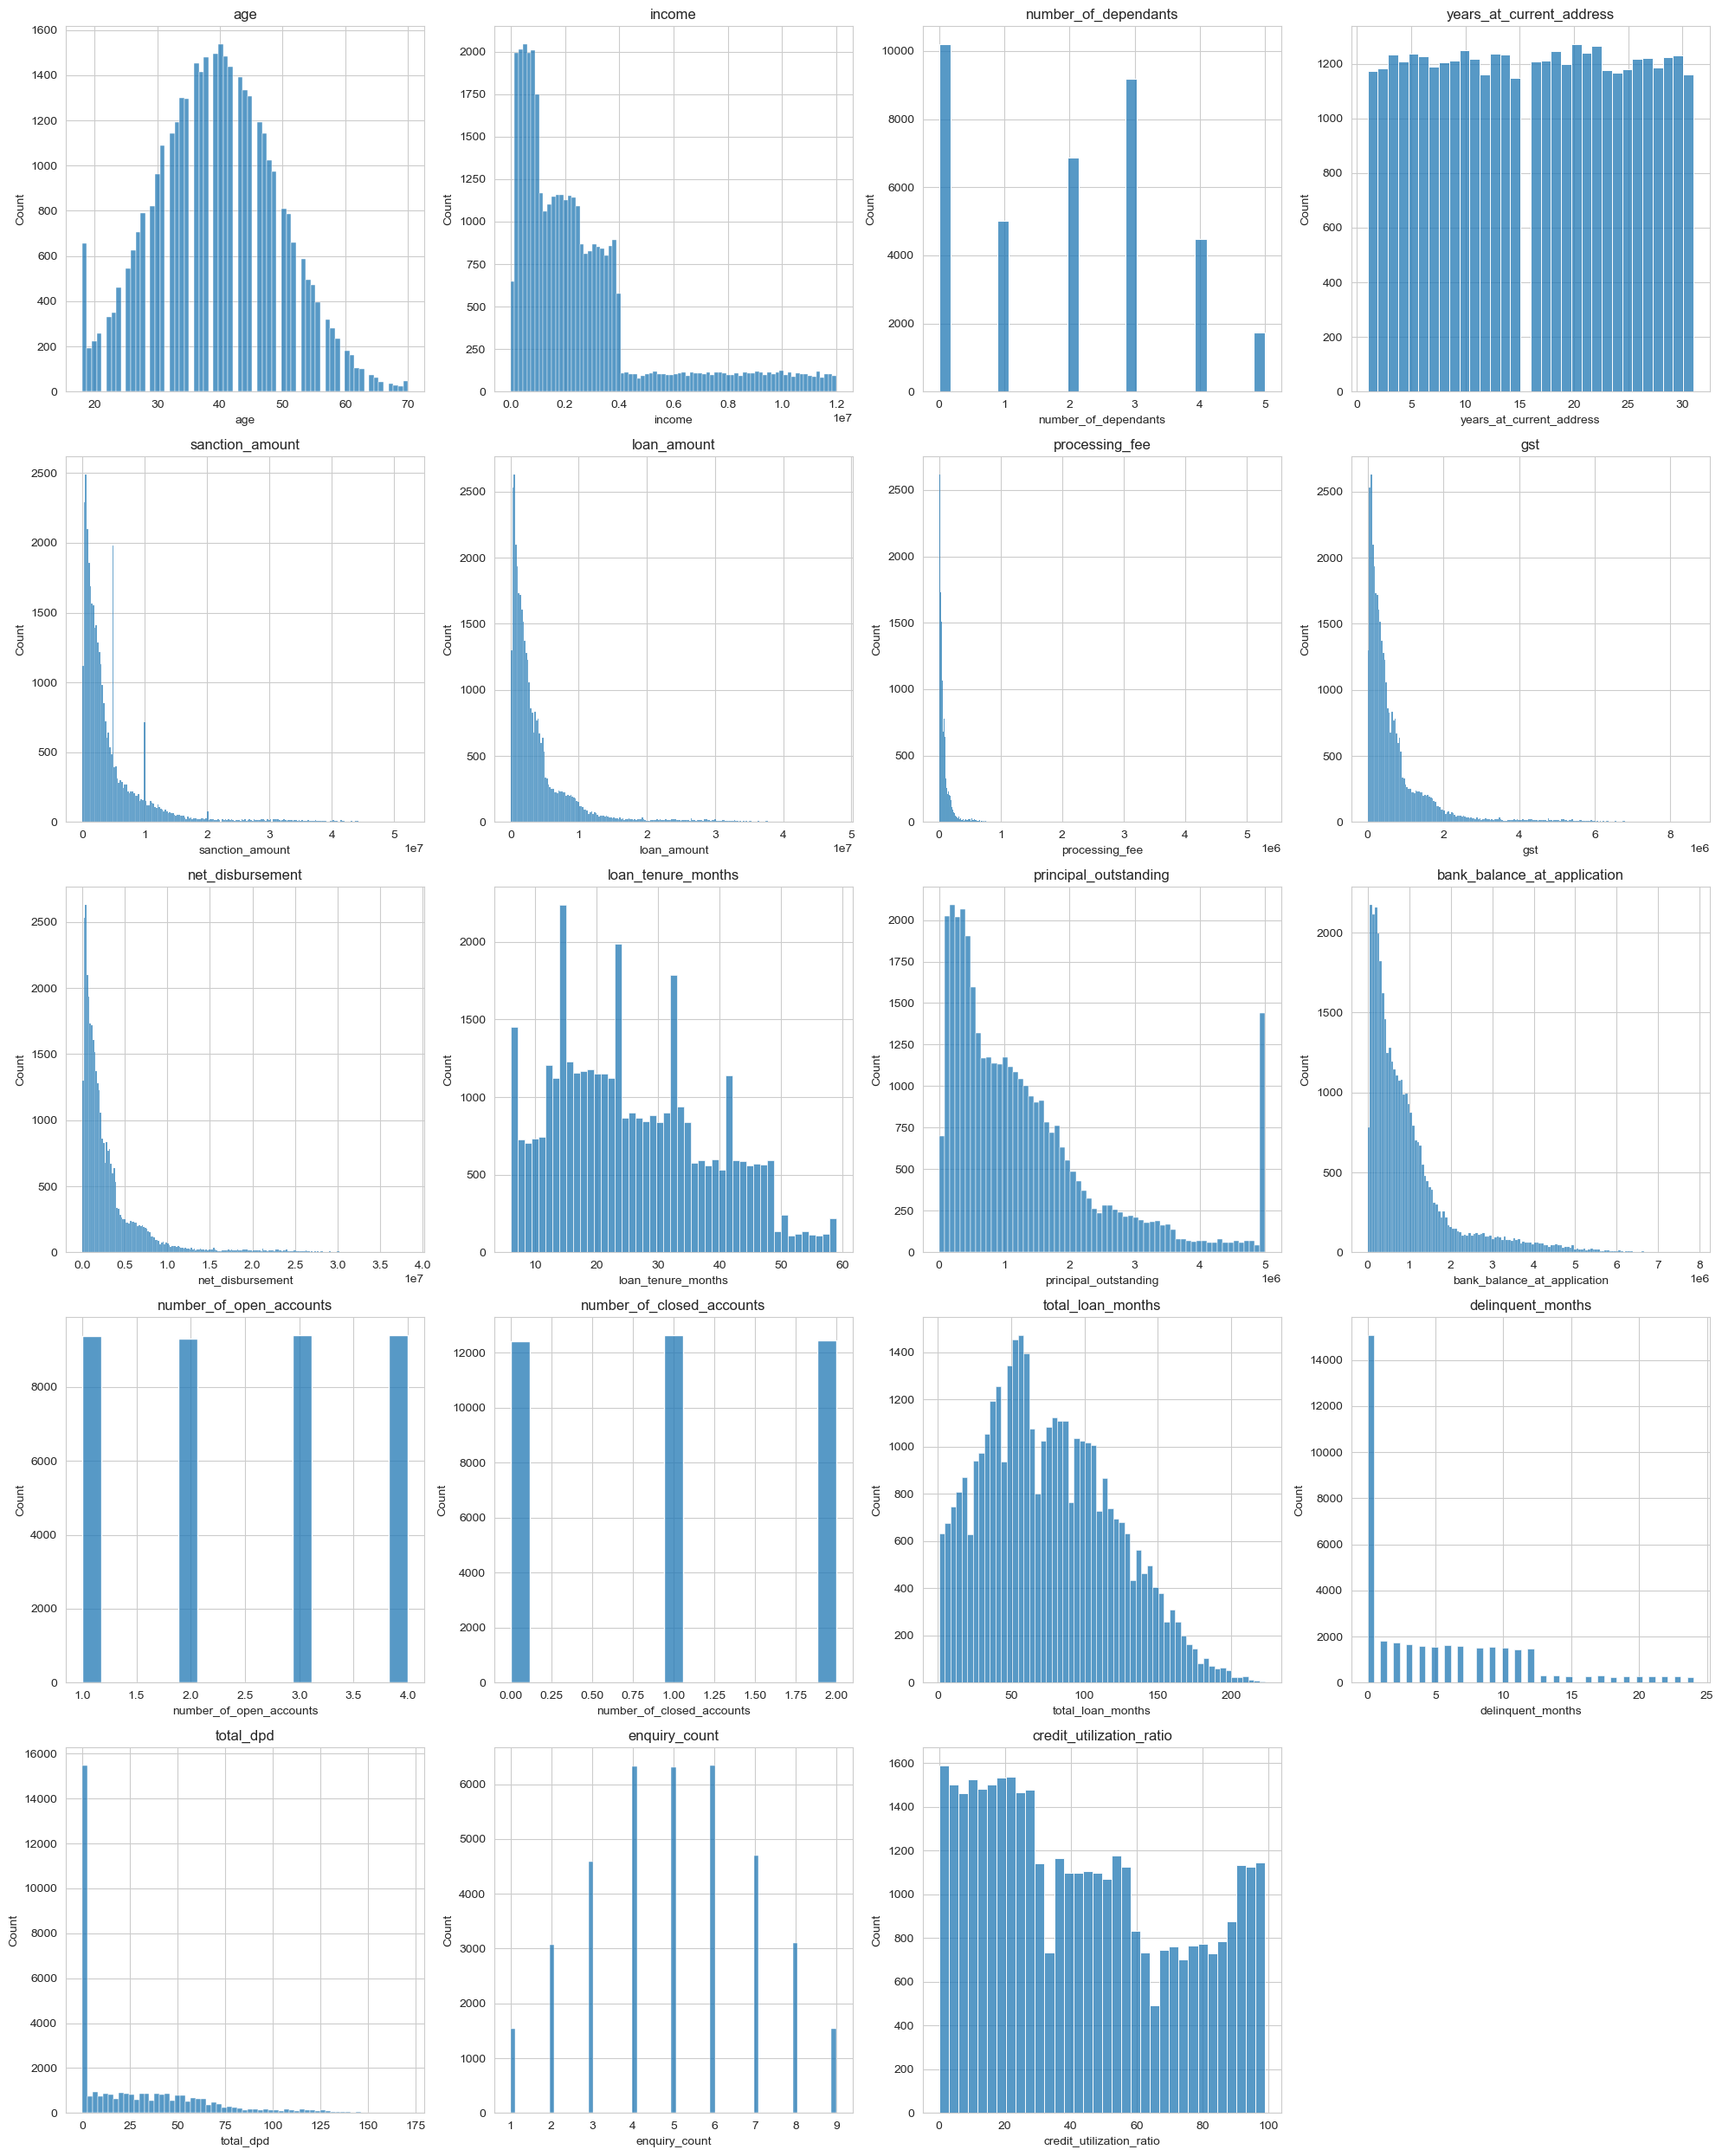

In [30]:
# Grid size (auto-calculated)
num_cols = 4
num_rows = math.ceil(len(numerical_cols) / num_cols) # Calculate the number of rows needed

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows))
axes = axes.flatten()  # Flatten in case of 1D row

# Plot each feature
for i, col in enumerate(numerical_cols):
    ax = axes[i]
    sns.histplot(x=train_df[col], ax=ax)
    ax.set_title(col) # Set the title to the name of the variable

# Hide unused subplots (if any)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Explore Processing Fee column

In [31]:
train_df.processing_fee.describe()

count     37500.00
mean      80290.68
std      113128.14
min           0.00
25%       19220.00
50%       44600.00
75%       92420.00
max     5293543.52
Name: processing_fee, dtype: float64

5293544 processing fee is very high. We will look for record where processing fee is more than loan amount

In [32]:
train_df[train_df.processing_fee > train_df.loan_amount][["processing_fee", "loan_amount"]]

,processing_fee,loan_amount
23981,2669791.02,2234000
28174,1214492.67,966000
47089,1858964.77,1738000
29305,3036378.01,2616000
9898,5293543.52,3626000


5 rows having processing fee more than loan amount which is outlier. And speak with business management about this and suggestes that processing fee is about 2-3% of loan amount.
So, any amount more than that is outliers. And this show the same records.

In [33]:
train_df[(train_df.processing_fee / train_df.loan_amount) > 0.03][["processing_fee", "loan_amount"]]

,processing_fee,loan_amount
23981,2669791.02,2234000
28174,1214492.67,966000
47089,1858964.77,1738000
29305,3036378.01,2616000
9898,5293543.52,3626000


We will processed with except these value, meaning record whose processing fee is less than 3% of loan amount.

In [34]:
# Removed outliers from Train dataset
train_df = train_df[(train_df.processing_fee / train_df.loan_amount) < 0.03].copy()
train_df[(train_df.processing_fee / train_df.loan_amount) > 0.03][["processing_fee", "loan_amount"]]

,processing_fee,loan_amount


In [35]:
# Removed outliers from Test dataset
test_df = test_df[(test_df.processing_fee / test_df.loan_amount) < 0.03].copy()
test_df[(test_df.processing_fee / test_df.loan_amount) > 0.03][["processing_fee", "loan_amount"]]

,processing_fee,loan_amount


In [36]:
train_df[(train_df.sanction_amount < train_df.loan_amount)]

,cust_id,age,gender,marital_status,employment_status,income,number_of_dependants,residence_type,years_at_current_address,city,state,zipcode,number_of_open_accounts,number_of_closed_accounts,total_loan_months,delinquent_months,total_dpd,enquiry_count,credit_utilization_ratio,loan_id,loan_purpose,loan_type,sanction_amount,loan_amount,processing_fee,gst,net_disbursement,loan_tenure_months,principal_outstanding,bank_balance_at_application,disbursal_date,installment_start_dt,default


### Explore GST column

In [37]:
train_df.gst.describe()

count     37488.00
mean     719468.76
std      967031.32
min       10080.00
25%      173115.00
50%      401400.00
75%      831600.00
max     8607420.00
Name: gst, dtype: float64

In [38]:
test_df[(test_df.gst / test_df.loan_amount) > 0.18][["gst", "loan_amount"]]

,gst,loan_amount


gst column is clear there is not any outliers.

### Explore Categorical Feature

In [39]:
for col in categorical_cols:
    print(col, ": " , train_df[col].unique())

gender :  ['M' 'F']
marital_status :  ['Married' 'Single']
employment_status :  ['Self-Employed' 'Salaried']
residence_type :  ['Owned' 'Mortgage' 'Rented']
city :  ['Hyderabad' 'Mumbai' 'Chennai' 'Bangalore' 'Pune' 'Kolkata' 'Ahmedabad'
 'Delhi' 'Lucknow' 'Jaipur']
state :  ['Telangana' 'Maharashtra' 'Tamil Nadu' 'Karnataka' 'West Bengal'
 'Gujarat' 'Delhi' 'Uttar Pradesh' 'Rajasthan']
zipcode :  [500001 400001 600001 560001 411001 700001 380001 110001 226001 302001]
loan_purpose :  ['Home' 'Education' 'Personal' 'Auto' 'Personaal']
loan_type :  ['Secured' 'Unsecured']
default :  [0 1]


In [40]:
# Replace Personaal with Personal as typo error from train df
train_df['loan_purpose'] = train_df['loan_purpose'].replace('Personaal', 'Personal')
train_df.loan_purpose.unique()

array(['Home', 'Education', 'Personal', 'Auto'], dtype=object)

In [41]:
# Replace Personaal with Personal as typo error from test df
test_df['loan_purpose'] = test_df['loan_purpose'].replace('Personaal', 'Personal')
test_df.loan_purpose.unique()

array(['Home', 'Education', 'Auto', 'Personal'], dtype=object)

## EDA

In [42]:
numerical_cols

['age',
 'income',
 'number_of_dependants',
 'years_at_current_address',
 'sanction_amount',
 'loan_amount',
 'processing_fee',
 'gst',
 'net_disbursement',
 'loan_tenure_months',
 'principal_outstanding',
 'bank_balance_at_application',
 'number_of_open_accounts',
 'number_of_closed_accounts',
 'total_loan_months',
 'delinquent_months',
 'total_dpd',
 'enquiry_count',
 'credit_utilization_ratio']

### Univariant Analysis

In [43]:
train_df.groupby(["default"])["age"].describe()

,count,mean,std,min,25%,50%,75%,max
default,,,,,,,,
0,34265.00,39.77,9.88,18.00,33.00,40.00,46.00,70.00
1,3223.00,37.12,9.29,18.00,31.00,37.00,44.00,70.00


**Insights**

target = 1 → defaulted (bad loan)

target = 0 → not defaulted (good loan)

1. Average age in the default group is little less (37.12) than the average (39.7) of the group that did not default
1. Variability (standard deviation) is mostly similar in both the groups
1. Both the groups have similar min and max ages

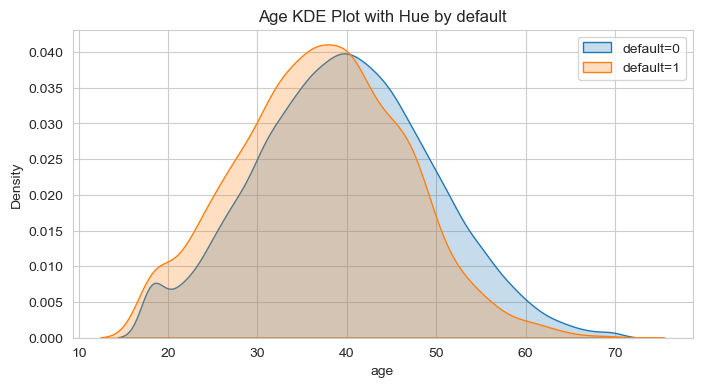

In [44]:
plt.figure(figsize=(8, 4))
sns.kdeplot(train_df['age'][train_df['default'] == 0], fill=True, label='default=0')
sns.kdeplot(train_df['age'][train_df['default'] == 1], fill=True, label='default=1')
plt.title(f"Age KDE Plot with Hue by default")
plt.legend()
plt.show()

**Insights**

1. Orange (defaulted) group is slightly shifted to left indicating that younger folks are more likely to default on their loans

### KDE for all the Columns

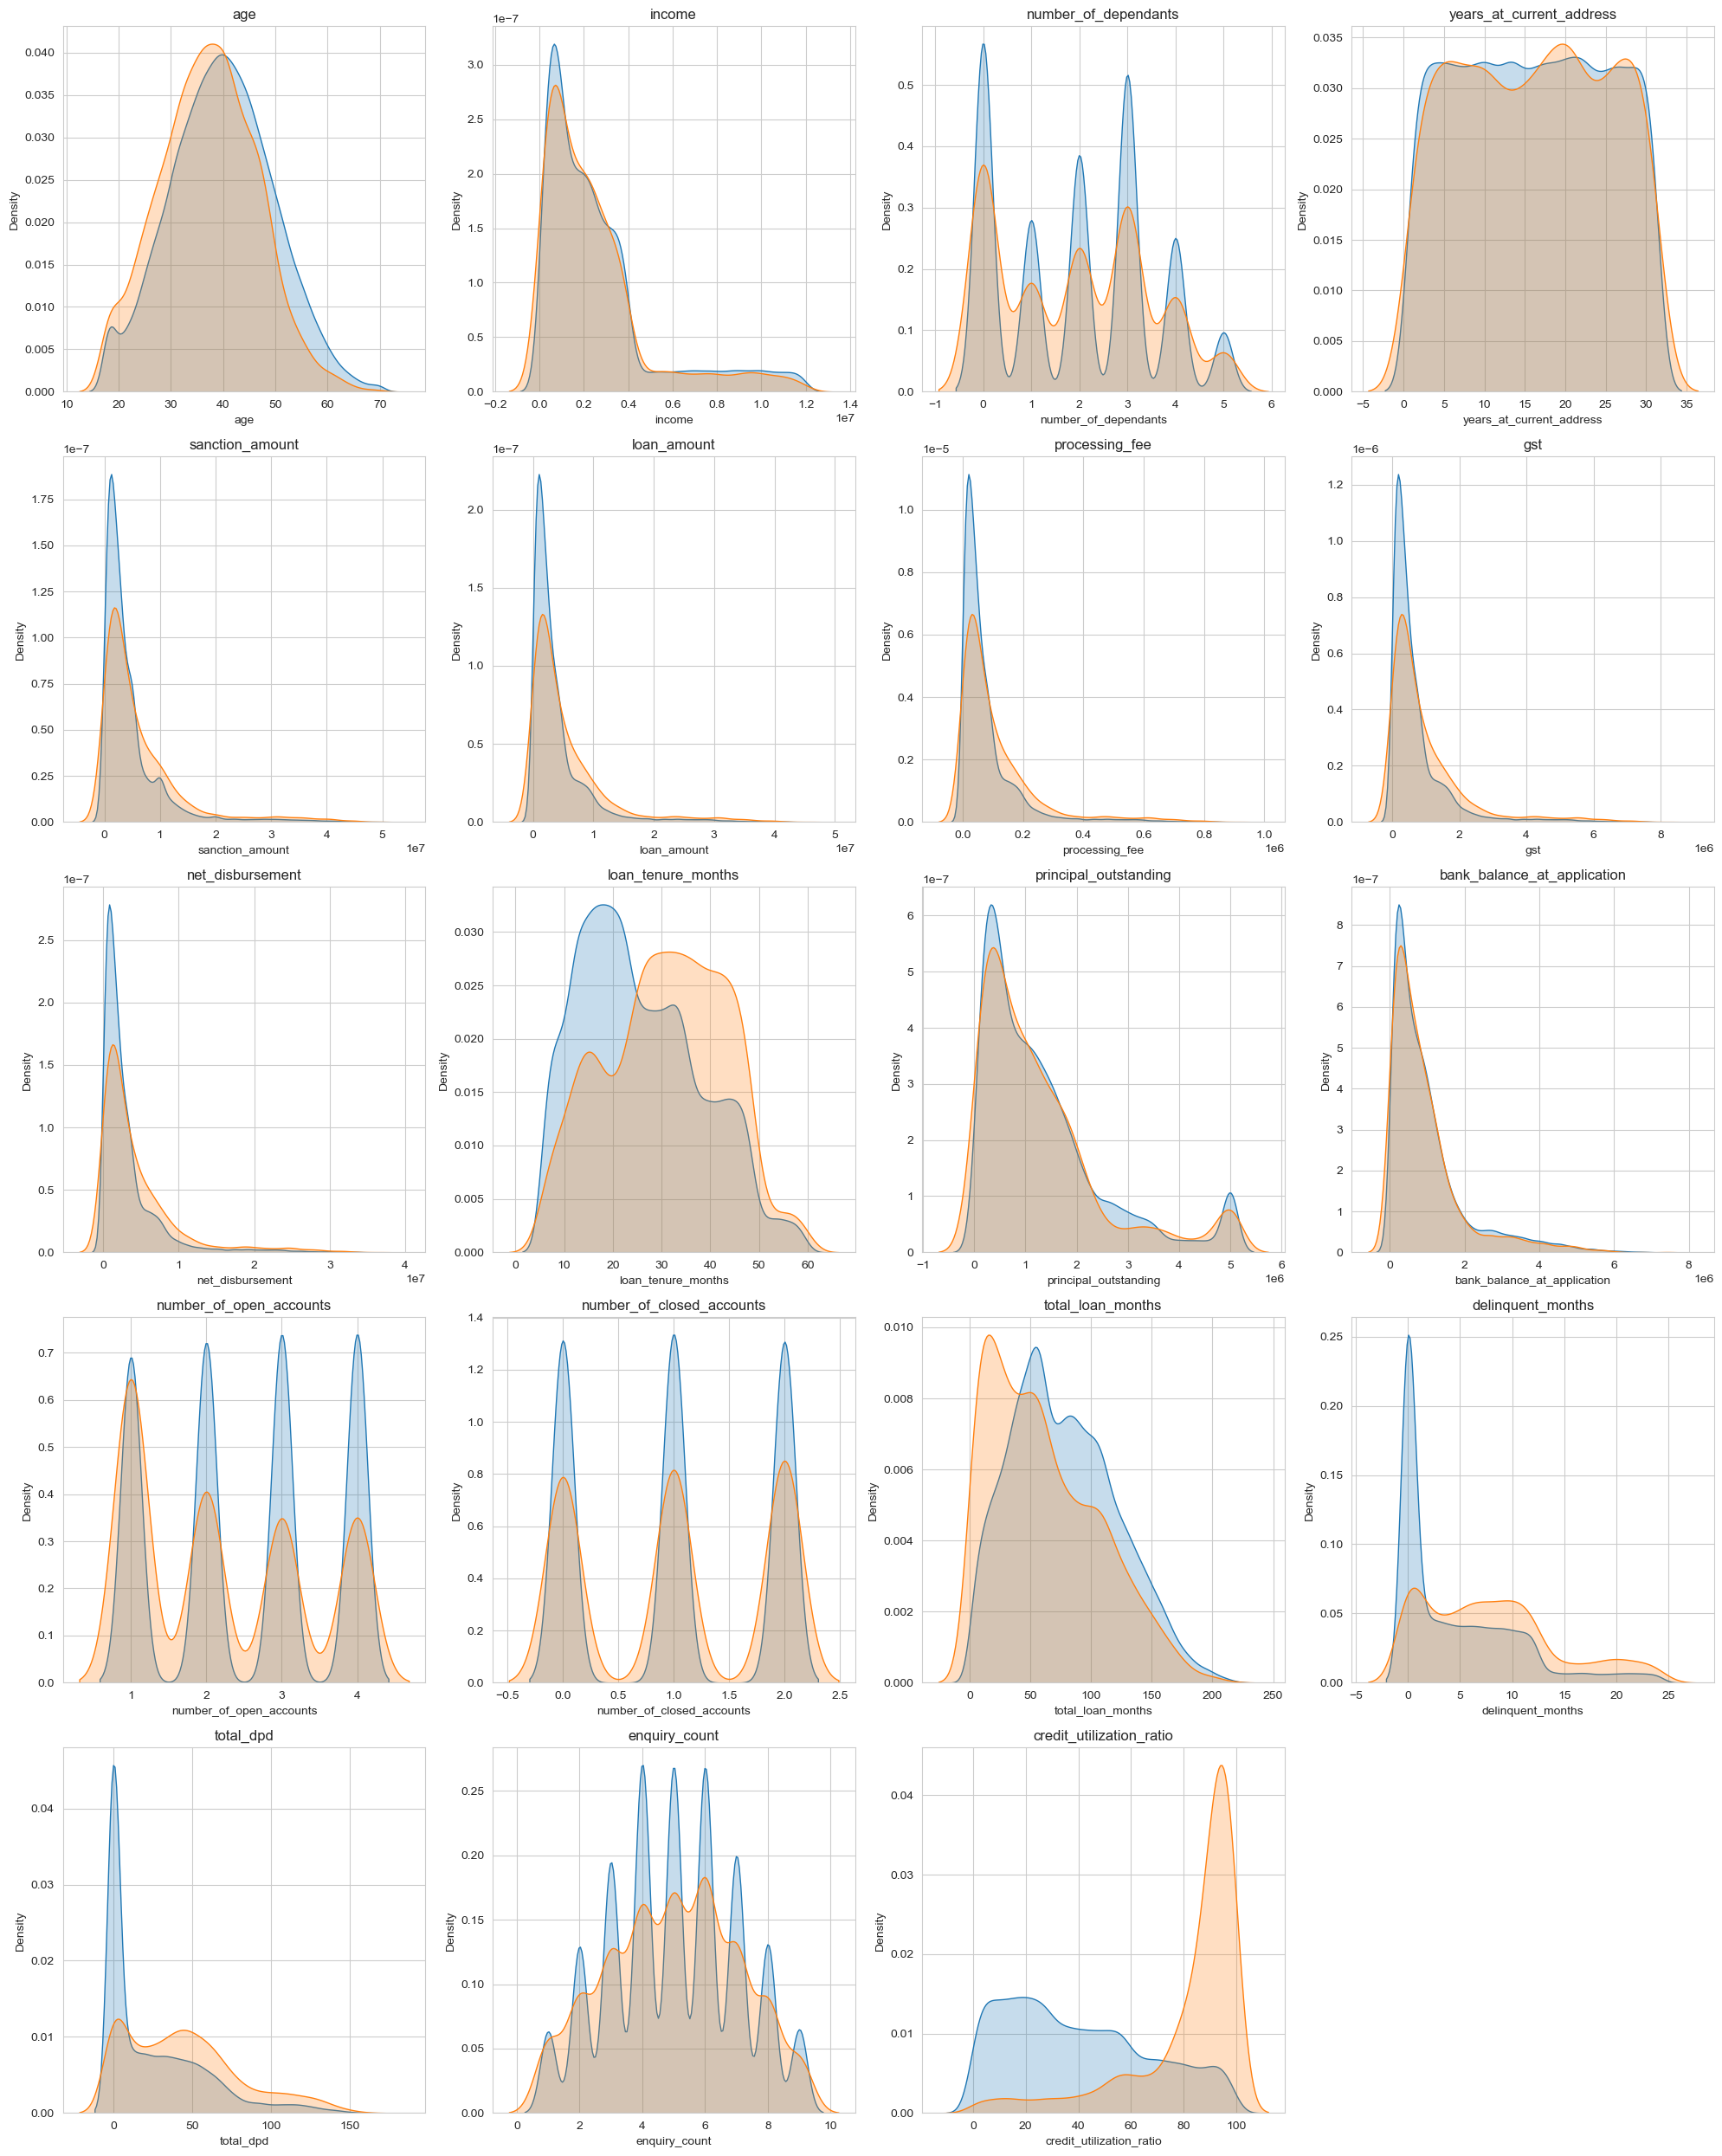

In [45]:
num_cols = 4
num_rows = math.ceil(len(numerical_cols) / num_cols) # Calculate the number of rows needed

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows))
axes = axes.flatten()

# Plot each feature
for i, col in enumerate(numerical_cols):
    ax = axes[i]
    sns.kdeplot(train_df[col][train_df['default'] == 0], fill=True, label='default=0', ax=ax)
    sns.kdeplot(train_df[col][train_df['default'] == 1], fill=True, label='default=1', ax=ax)
    ax.set_title(col) # Set the title to the name of the variable

# Remove unused axes
for j in range(len(numerical_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

**Insights**

1. In columns: loan_tenure_months, delinquent_months, total_dpd, credit_utilization, higher values indicate high likelyhood of becoming a default. Hence these 4 looks like strong predictors
1. In remaining columns the distributions do not give any obvious insights
1. Why loan_amount and income did not give any signs of being strong predictors? May be when we combine these two and get loan to income ratio (LTI), that may have influence on the target variable. We will explore more later

## Feature Engineering

Description
1. Please discuss with the business the assumptions for data cleaning and missing value imputation
2. Here are the suggestions for feature engineering

    a. Loan to Income ratio is a better metric compared to loan amount and income as individual features

    b. Delinquent month to loan months ratio is a better metric compared to those two individual
    features.

    c. Average DPD per delinquent month is a better metric compared to total dpd and total delinquent months

In [46]:
fe_train_df = train_df.copy()
fe_test_df = test_df.copy()

##### a. Loan to Income ratio is a better metric compared to loan amount and income as individual features

In [47]:

fe_train_df['loan_to_income'] = fe_train_df['loan_amount']/fe_train_df['income']
fe_test_df['loan_to_income'] = fe_test_df['loan_amount']/fe_test_df['income']
fe_train_df['loan_to_income'].describe()

count   37488.00
mean        1.56
std         0.97
min         0.30
25%         0.77
50%         1.16
75%         2.46
max         4.57
Name: loan_to_income, dtype: float64

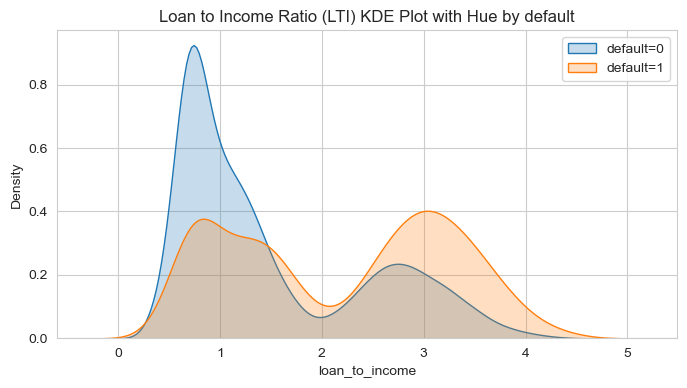

In [48]:
plt.figure(figsize=(8, 4))
sns.kdeplot(fe_train_df['loan_to_income'][fe_train_df['default'] == 0], fill=True, label='default=0')
sns.kdeplot(fe_train_df['loan_to_income'][fe_train_df['default'] == 1], fill=True, label='default=1')
plt.title(f"Loan to Income Ratio (LTI) KDE Plot with Hue by default")
plt.legend()
plt.show()

**Insights**
1. Blue graph has majority of its values on lower side of LTI
2. Orange graph has many values when LTI is higher indicating that higher LTI means high risk loan.
3. LTI ratio also be less in order to not defaulted.

##### b. Delinquent month to loan months ratio is a better metric compared to those two individual features.

In [49]:
fe_train_df['delinquency_ratio'] = round((fe_train_df['delinquent_months'] / fe_train_df['total_loan_months']) * 100, 2)
fe_train_df[['delinquent_months', 'total_loan_months', 'delinquency_ratio']].head(3)

,delinquent_months,total_loan_months,delinquency_ratio
12746,20,152,13.16
32495,10,160,6.25
43675,12,54,22.22


In [50]:

fe_test_df['delinquency_ratio'] = round((fe_test_df['delinquent_months'] / fe_test_df['total_loan_months']) * 100, 2)
fe_test_df[['delinquent_months', 'total_loan_months', 'delinquency_ratio']].head(3)

,delinquent_months,total_loan_months,delinquency_ratio
19205,0,42,0.00
15514,0,125,0.00
30367,0,76,0.00


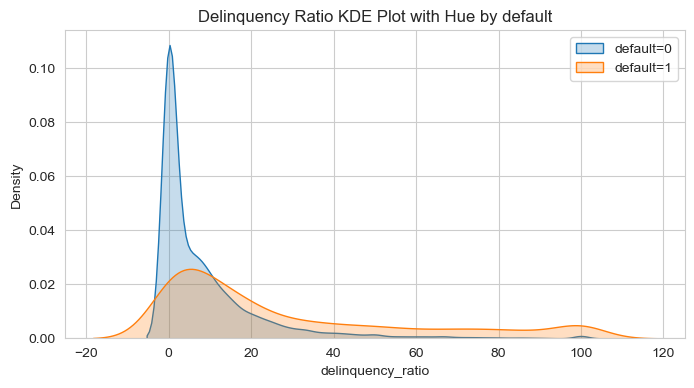

In [51]:
plt.figure(figsize=(8, 4))
sns.kdeplot(fe_train_df['delinquency_ratio'][fe_train_df['default'] == 0], fill=True, label='default=0')
sns.kdeplot(fe_train_df['delinquency_ratio'][fe_train_df['default'] == 1], fill=True, label='default=1')
plt.title(f"Delinquency Ratio KDE Plot with Hue by default")
plt.legend()
plt.show()

**Insights**
1. Blue graph has majority of its values on lower side of LTI
2. Orange graph has many values when delinquency ratio is higher indicating some correlation on default

##### c. Average DPD per delinquent month is a better metric compared to total dpd and total delinquent months

In [52]:
fe_train_df['avg_dpd_per_delinquency'] = np.where(
    fe_train_df['delinquent_months'] != 0,
    fe_train_df['total_dpd'] / fe_train_df['delinquent_months'],
    0
).round(2)
fe_train_df['avg_dpd_per_delinquency'].isna().sum()

0

In [53]:
fe_test_df['avg_dpd_per_delinquency'] = np.where(
    fe_test_df['delinquent_months'] != 0,
    fe_test_df['total_dpd'] / fe_test_df['delinquent_months'],
    0
).round(2)
fe_test_df['avg_dpd_per_delinquency'].isna().sum()

0

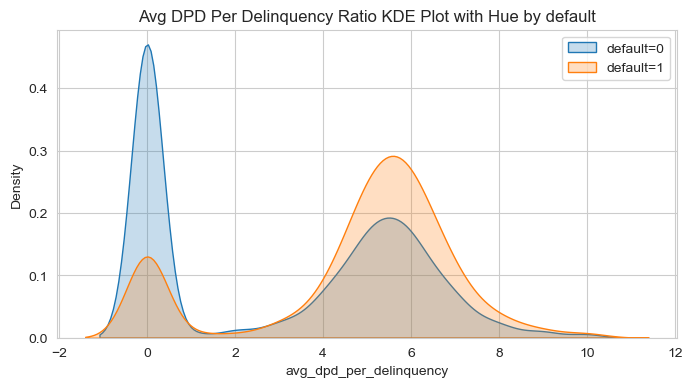

In [54]:
plt.figure(figsize=(8, 4))
sns.kdeplot(fe_train_df['avg_dpd_per_delinquency'][fe_train_df['default'] == 0], fill=True, label='default=0')
sns.kdeplot(fe_train_df['avg_dpd_per_delinquency'][fe_train_df['default'] == 1], fill=True, label='default=1')
plt.title(f"Avg DPD Per Delinquency Ratio KDE Plot with Hue by default")
plt.legend()
plt.show()

**Insights**

1. Graph clearly shows more occurances of default cases when avg_dpd_per_delinquency is high. This means this column is a strong predictor

### Remove columns that are just unique ids and don't have influence on target

In [55]:
fe_train_df = fe_train_df.drop(['cust_id', 'loan_id'],axis=1)
fe_test_df = fe_test_df.drop(['cust_id', 'loan_id'],axis=1)

### Remove columns that business contact person asked us to remove

In [56]:
fe_train_df = fe_train_df.drop(['disbursal_date', 'installment_start_dt', 'loan_amount', 'income', 'sanction_amount',
                              'total_loan_months', 'delinquent_months', 'total_dpd'], axis=1)
fe_test_df = fe_test_df.drop(['disbursal_date', 'installment_start_dt', 'loan_amount', 'income', 'sanction_amount',
                              'total_loan_months', 'delinquent_months', 'total_dpd'], axis=1)
fe_train_df.columns

Index(['age', 'gender', 'marital_status', 'employment_status',
       'number_of_dependants', 'residence_type', 'years_at_current_address',
       'city', 'state', 'zipcode', 'number_of_open_accounts',
       'number_of_closed_accounts', 'enquiry_count',
       'credit_utilization_ratio', 'loan_purpose', 'loan_type',
       'processing_fee', 'gst', 'net_disbursement', 'loan_tenure_months',
       'principal_outstanding', 'bank_balance_at_application', 'default',
       'loan_to_income', 'delinquency_ratio', 'avg_dpd_per_delinquency'],
      dtype='object')

In [57]:
fe_train_df.select_dtypes(['int64', 'float64']).columns

Index(['age', 'number_of_dependants', 'years_at_current_address', 'zipcode',
       'number_of_open_accounts', 'number_of_closed_accounts', 'enquiry_count',
       'credit_utilization_ratio', 'processing_fee', 'gst', 'net_disbursement',
       'loan_tenure_months', 'principal_outstanding',
       'bank_balance_at_application', 'default', 'loan_to_income',
       'delinquency_ratio', 'avg_dpd_per_delinquency'],
      dtype='object')

In [58]:
X_train = fe_train_df.drop('default', axis=1)
y_train = fe_train_df['default']

In [59]:
fe_test_df

,age,gender,marital_status,employment_status,number_of_dependants,residence_type,years_at_current_address,city,state,zipcode,number_of_open_accounts,number_of_closed_accounts,enquiry_count,credit_utilization_ratio,loan_purpose,loan_type,processing_fee,gst,net_disbursement,loan_tenure_months,principal_outstanding,bank_balance_at_application,default,loan_to_income,delinquency_ratio,avg_dpd_per_delinquency
19205,36,M,Married,Self-Employed,3,Owned,24,Jaipur,Rajasthan,302001,2,1,5,98,Home,Secured,197800.00,1780200,7912000,46,1745379,806208,0,2.65,0.00,0.00
15514,43,F,Single,Self-Employed,0,Owned,23,Delhi,Delhi,110001,4,0,5,32,Education,Secured,61740.00,555660,2469600,18,1675530,1019647,0,1.24,0.00,0.00
30367,30,M,Married,Self-Employed,4,Owned,27,Delhi,Delhi,110001,3,0,6,82,Auto,Secured,66460.00,598140,2658400,35,1613282,1000932,0,1.07,0.00,0.00
35347,37,F,Single,Salaried,2,Owned,5,Pune,Maharashtra,411001,4,2,7,48,Home,Secured,31180.00,280620,1247200,46,398614,167679,0,2.74,2.40,7.00
41814,48,F,Single,Salaried,0,Mortgage,23,Chennai,Tamil Nadu,600001,3,1,8,97,Home,Secured,27020.00,243180,1080800,44,383925,262180,1,2.04,10.69,6.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29297,27,M,Single,Self-Employed,0,Owned,3,Jaipur,Rajasthan,302001,3,0,8,52,Auto,Secured,5060.00,45540,202400,29,96645,65285,0,1.37,4.81,2.80
20567,40,M,Single,Self-Employed,0,Rented,19,Kolkata,West Bengal,700001,1,1,5,5,Home,Secured,27260.00,245340,1090400,35,273282,158171,0,3.17,0.00,0.00
681,28,M,Married,Self-Employed,5,Rented,15,Bangalore,Karnataka,560001,2,2,4,54,Personal,Unsecured,73200.00,658800,2928000,15,2635199,4652930,0,0.31,6.25,3.50
33682,31,M,Single,Salaried,1,Owned,29,Delhi,Delhi,110001,1,0,4,85,Home,Secured,250680.00,2256120,10027200,37,1907851,1029321,0,3.65,0.00,0.00


In [60]:
## Feature Selection

### VIF to measure multicolinearity

In [61]:
cols_to_scale = X_train.select_dtypes(['int64','float64']).columns.drop(['zipcode'])
cols_to_scale

Index(['age', 'number_of_dependants', 'years_at_current_address',
       'number_of_open_accounts', 'number_of_closed_accounts', 'enquiry_count',
       'credit_utilization_ratio', 'processing_fee', 'gst', 'net_disbursement',
       'loan_tenure_months', 'principal_outstanding',
       'bank_balance_at_application', 'loan_to_income', 'delinquency_ratio',
       'avg_dpd_per_delinquency'],
      dtype='object')

In [62]:
scaler = MinMaxScaler()
X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])

In [63]:
X_train.describe()

,age,number_of_dependants,years_at_current_address,zipcode,number_of_open_accounts,number_of_closed_accounts,enquiry_count,credit_utilization_ratio,processing_fee,gst,net_disbursement,loan_tenure_months,principal_outstanding,bank_balance_at_application,loan_to_income,delinquency_ratio,avg_dpd_per_delinquency
count,37488.00,37488.00,37488.00,37488.00,37488.00,37488.00,37488.00,37488.00,37488.00,37488.00,37488.00,37488.00,37488.00,37488.00,37488.00,37488.00,37488.00
mean,0.41,0.39,0.50,418876.24,0.50,0.50,0.50,0.44,0.08,0.08,0.08,0.38,0.26,0.12,0.29,0.10,0.33
std,0.19,0.31,0.30,169029.87,0.37,0.41,0.25,0.30,0.11,0.11,0.11,0.23,0.24,0.13,0.23,0.17,0.29
min,0.00,0.00,0.00,110001.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.29,0.00,0.23,302001.00,0.00,0.00,0.38,0.18,0.02,0.02,0.02,0.19,0.08,0.03,0.11,0.00,0.00
50%,0.40,0.40,0.50,400001.00,0.67,0.50,0.50,0.39,0.05,0.05,0.05,0.34,0.19,0.08,0.20,0.04,0.43
75%,0.54,0.60,0.77,560001.00,1.00,1.00,0.62,0.68,0.10,0.10,0.10,0.55,0.35,0.16,0.51,0.13,0.57
max,1.00,1.00,1.00,700001.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


#### Same transformation on test set

In [64]:
X_test = fe_test_df.drop('default', axis='columns')
y_test = fe_test_df['default']

X_test[cols_to_scale] = scaler.transform(X_test[cols_to_scale])
X_test.describe()

,age,number_of_dependants,years_at_current_address,zipcode,number_of_open_accounts,number_of_closed_accounts,enquiry_count,credit_utilization_ratio,processing_fee,gst,net_disbursement,loan_tenure_months,principal_outstanding,bank_balance_at_application,loan_to_income,delinquency_ratio,avg_dpd_per_delinquency
count,12497.00,12497.00,12497.00,12497.00,12497.00,12497.00,12497.00,12497.00,12497.00,12497.00,12497.00,12497.00,12497.00,12497.00,12497.00,12497.00,12497.00
mean,0.42,0.38,0.50,419759.82,0.50,0.50,0.50,0.44,0.08,0.08,0.08,0.38,0.26,0.12,0.29,0.11,0.33
std,0.19,0.31,0.30,168845.35,0.37,0.41,0.25,0.30,0.11,0.11,0.11,0.23,0.25,0.13,0.23,0.17,0.29
min,0.00,0.00,0.00,110001.00,0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,0.00
25%,0.29,0.00,0.23,302001.00,0.00,0.00,0.38,0.18,0.02,0.02,0.02,0.19,0.08,0.03,0.11,0.00,0.00
50%,0.42,0.40,0.50,411001.00,0.33,0.50,0.50,0.39,0.05,0.05,0.05,0.34,0.20,0.08,0.20,0.04,0.44
75%,0.54,0.60,0.77,560001.00,0.67,1.00,0.62,0.68,0.09,0.09,0.09,0.55,0.36,0.16,0.50,0.13,0.58
max,1.00,1.00,1.00,700001.00,1.00,1.00,1.00,1.00,0.96,0.96,0.96,1.00,1.00,0.94,1.01,1.00,1.00


In [65]:
def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df['Column'] = data.columns
    vif_df['VIF'] = [variance_inflation_factor(data.values,i) for i in range(data.shape[1])]
    return vif_df
vif_df = calculate_vif(X_train[cols_to_scale])

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [66]:
features_to_drop_vif = ['processing_fee', 'gst', 'net_disbursement','principal_outstanding']


X_train_new = X_train.drop(features_to_drop_vif, axis='columns')
numeric_columns = X_train_new.select_dtypes(['int64', 'float64']).columns
numeric_columns

Index(['age', 'number_of_dependants', 'years_at_current_address', 'zipcode',
       'number_of_open_accounts', 'number_of_closed_accounts', 'enquiry_count',
       'credit_utilization_ratio', 'loan_tenure_months',
       'bank_balance_at_application', 'loan_to_income', 'delinquency_ratio',
       'avg_dpd_per_delinquency'],
      dtype='object')

In [67]:
vif_df = calculate_vif(X_train_new[numeric_columns])
vif_df

,Column,VIF
0,age,5.53
1,number_of_dependants,2.73
2,years_at_current_address,3.45
3,zipcode,5.61
4,number_of_open_accounts,4.36
5,number_of_closed_accounts,2.39
6,enquiry_count,6.44
7,credit_utilization_ratio,2.95
8,loan_tenure_months,6.03
9,bank_balance_at_application,1.81


In [68]:
selected_numeric_features_vif = vif_df.Column.values
selected_numeric_features_vif

array(['age', 'number_of_dependants', 'years_at_current_address',
       'zipcode', 'number_of_open_accounts', 'number_of_closed_accounts',
       'enquiry_count', 'credit_utilization_ratio', 'loan_tenure_months',
       'bank_balance_at_application', 'loan_to_income',
       'delinquency_ratio', 'avg_dpd_per_delinquency'], dtype=object)

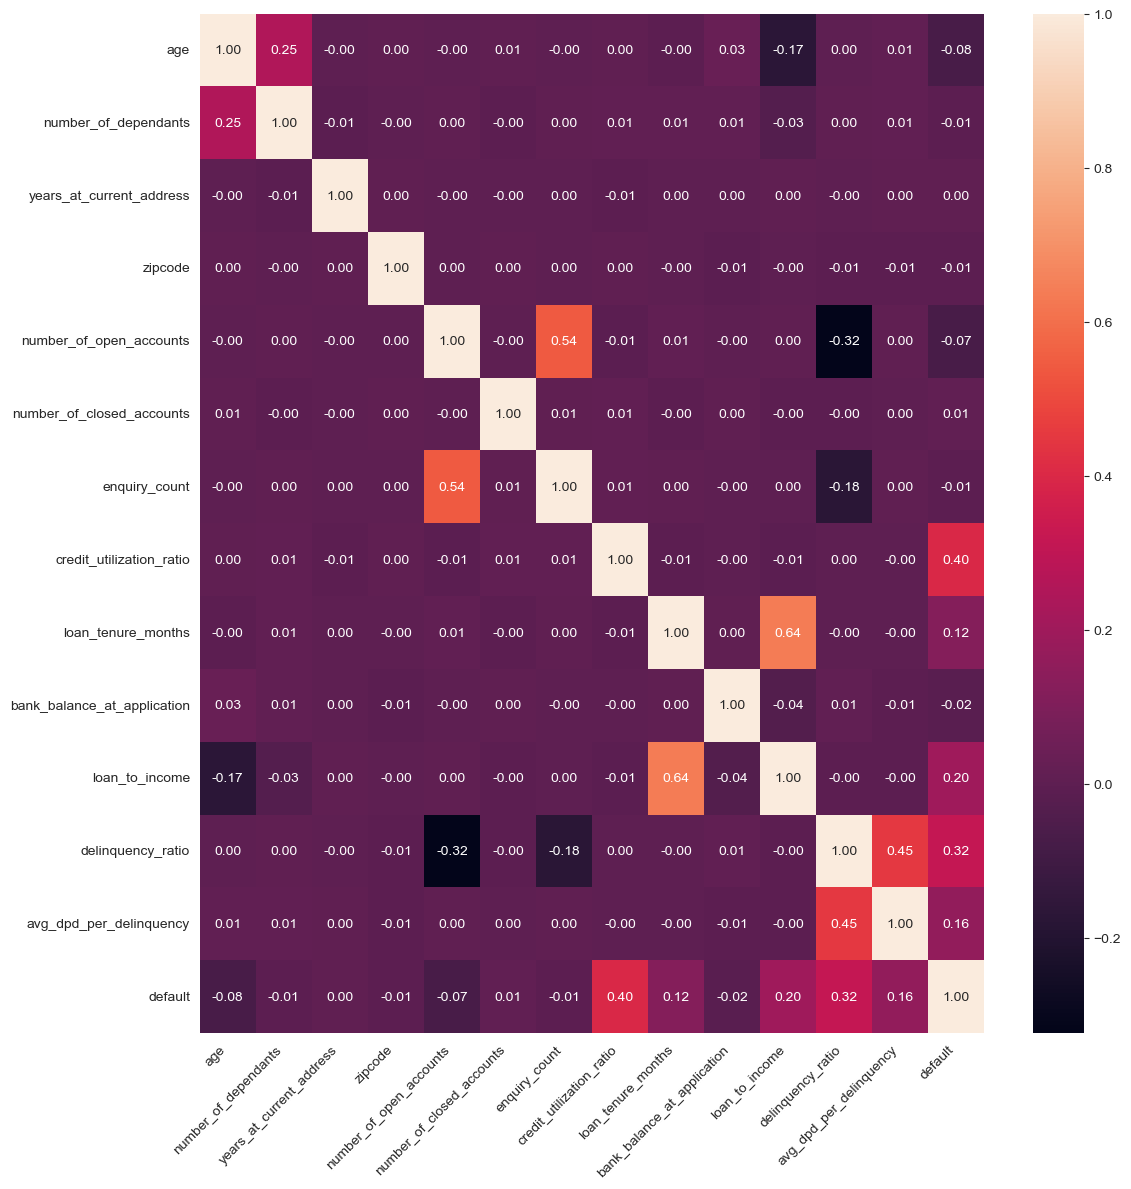

In [69]:
plt.figure(figsize=(12,12))
cm = fe_train_df[numeric_columns.append(pd.Index(['default']))].corr()
sns.heatmap(cm, annot=True, fmt='0.2f')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

#### Weight of Evidence (WOE) and Information Value (IF)

To find the infulance for categorical variable on Target variable. WOE and IF are most popular statistical technique used for finding infulance of categorical fetaure specially in Credit Risk Modeling.

### Feature Selection: Categorical Features

In [70]:
X_train_new.head()

,age,gender,marital_status,employment_status,number_of_dependants,residence_type,years_at_current_address,city,state,zipcode,number_of_open_accounts,number_of_closed_accounts,enquiry_count,credit_utilization_ratio,loan_purpose,loan_type,loan_tenure_months,bank_balance_at_application,loan_to_income,delinquency_ratio,avg_dpd_per_delinquency
12746,0.79,M,Married,Self-Employed,0.60,Owned,0.97,Hyderabad,Telangana,500001,1.00,1.00,0.38,0.36,Home,Secured,0.42,0.61,0.42,0.13,0.59
32495,0.50,F,Single,Salaried,0.00,Owned,0.87,Mumbai,Maharashtra,400001,0.67,0.50,0.50,0.05,Education,Secured,0.83,0.03,0.31,0.06,0.62
43675,0.38,M,Single,Salaried,0.00,Mortgage,0.83,Chennai,Tamil Nadu,600001,0.00,0.50,0.38,0.00,Home,Secured,0.49,0.17,0.76,0.22,0.56
9040,0.46,M,Married,Salaried,0.40,Mortgage,0.97,Bangalore,Karnataka,560001,0.67,0.00,0.88,0.88,Education,Secured,0.64,0.08,0.19,0.00,0.00
13077,0.77,M,Married,Self-Employed,0.80,Owned,0.93,Pune,Maharashtra,411001,0.00,1.00,0.00,0.72,Personal,Unsecured,0.17,0.07,0.05,0.00,0.00


In [71]:
X_train_new.shape

(37488, 21)

In [72]:
categorical_cols

['gender',
 'marital_status',
 'employment_status',
 'residence_type',
 'city',
 'state',
 'zipcode',
 'loan_purpose',
 'loan_type',
 'default']

### Calculate WOE and IV

In [73]:
def calculate_woe_iv(df, feature, target):
    grouped = df.groupby(feature)[target].agg(['count','sum'])
    grouped = grouped.rename(columns={'count': 'total', 'sum':'good'})
    grouped['bad'] = grouped['total'] - grouped['good']
  

    total_good = grouped['good'].sum()
    total_bad = grouped['bad'].sum()
    
    grouped['good_pct'] = grouped['good'] / total_good
    grouped['bad_pct'] = grouped['bad'] / total_bad

    # WoE
    grouped['woe'] = np.log(grouped['good_pct'] / grouped['bad_pct'])

    # IV
    grouped['iv'] = (grouped['good_pct'] - grouped['bad_pct']) * grouped['woe']

    grouped['woe'] = grouped['woe'].replace([np.inf, -np.inf], 0)
    grouped['iv'] = grouped['iv'].replace([np.inf, -np.inf], 0)
    
    total_iv = grouped['iv'].sum()
    
    return grouped, total_iv
    # grouped

grouped, total_iv = calculate_woe_iv(pd.concat([X_train_new, y_train], axis=1), 'loan_purpose', 'default')
grouped, total_iv

(              total  good    bad  good_pct  bad_pct   woe   iv
 loan_purpose                                                  
 Auto           7447   327   7120      0.10     0.21 -0.72 0.08
 Education      5620   559   5061      0.17     0.15  0.16 0.00
 Home          11304  1734   9570      0.54     0.28  0.66 0.17
 Personal      13117   603  12514      0.19     0.37 -0.67 0.12,
 0.3691197842282755)

In [74]:
iv_values = {}

for feature in X_train_new.columns:
    if X_train_new[feature].dtype == 'object':
        _, iv = calculate_woe_iv(pd.concat([X_train_new, y_train],axis=1), feature, 'default' )
    else:
        X_binned = pd.cut(X_train_new[feature], bins=10, labels=False)
        _, iv = calculate_woe_iv(pd.concat([X_binned, y_train],axis=1), feature, 'default' )
    iv_values[feature] = iv
        
iv_values

{'age': 0.0890689462679479,
 'gender': 0.00047449502170914947,
 'marital_status': 0.001129766845390142,
 'employment_status': 0.003953046301722585,
 'number_of_dependants': 0.0019380899135053508,
 'residence_type': 0.246745268718145,
 'years_at_current_address': 0.0020800513608156363,
 'city': 0.0019059578709781529,
 'state': 0.0019005589806779287,
 'zipcode': 0.0016677413243392572,
 'number_of_open_accounts': 0.08463134083005877,
 'number_of_closed_accounts': 0.0011964272592421567,
 'enquiry_count': 0.007864214085342608,
 'credit_utilization_ratio': 2.352965568168245,
 'loan_purpose': 0.3691197842282755,
 'loan_type': 0.16319324904149224,
 'loan_tenure_months': 0.21893515090196278,
 'bank_balance_at_application': 0.0063187993277516365,
 'loan_to_income': 0.47572195076776647,
 'delinquency_ratio': 0.716576108689321,
 'avg_dpd_per_delinquency': 0.40176623566177694}

In [75]:
iv_df = pd.DataFrame(list(iv_values.items()), columns=['Feature', 'IV'])
iv_df = iv_df.sort_values(by='IV', ascending=False)
iv_df

,Feature,IV
13,credit_utilization_ratio,2.35
19,delinquency_ratio,0.72
18,loan_to_income,0.48
20,avg_dpd_per_delinquency,0.40
14,loan_purpose,0.37
5,residence_type,0.25
16,loan_tenure_months,0.22
15,loan_type,0.16
0,age,0.09
10,number_of_open_accounts,0.08


In [76]:
# select features that has IV > 0.02
selected_features_iv = [feature for feature, iv in iv_values.items() if iv > 0.02]
selected_features_iv

['age',
 'residence_type',
 'number_of_open_accounts',
 'credit_utilization_ratio',
 'loan_purpose',
 'loan_type',
 'loan_tenure_months',
 'loan_to_income',
 'delinquency_ratio',
 'avg_dpd_per_delinquency']

## Feature Encoding

In [77]:
X_train_reduced = X_train_new[selected_features_iv]
X_test_reduced = X_test[selected_features_iv]

In [78]:
X_train_reduced.shape, X_test_reduced.shape

((37488, 10), (12497, 10))

In [79]:
X_train_encoded = pd.get_dummies(X_train_reduced, drop_first=True)
X_train_encoded.head(3)

,age,number_of_open_accounts,credit_utilization_ratio,loan_tenure_months,loan_to_income,delinquency_ratio,avg_dpd_per_delinquency,residence_type_Owned,residence_type_Rented,loan_purpose_Education,loan_purpose_Home,loan_purpose_Personal,loan_type_Unsecured
12746,0.79,1.00,0.36,0.42,0.42,0.13,0.59,True,False,False,True,False,False
32495,0.50,0.67,0.05,0.83,0.31,0.06,0.62,True,False,True,False,False,False
43675,0.38,0.00,0.00,0.49,0.76,0.22,0.56,False,False,False,True,False,False


In [80]:
X_test_encoded = pd.get_dummies(X_test_reduced, drop_first=True)
X_test_encoded.head(3)

,age,number_of_open_accounts,credit_utilization_ratio,loan_tenure_months,loan_to_income,delinquency_ratio,avg_dpd_per_delinquency,residence_type_Owned,residence_type_Rented,loan_purpose_Education,loan_purpose_Home,loan_purpose_Personal,loan_type_Unsecured
19205,0.35,0.33,0.99,0.75,0.55,0.00,0.00,True,False,False,True,False,False
15514,0.48,1.00,0.32,0.23,0.22,0.00,0.00,True,False,True,False,False,False
30367,0.23,0.67,0.83,0.55,0.18,0.00,0.00,True,False,False,False,False,False


In [81]:
X_train_encoded.shape, X_test_encoded.shape

((37488, 13), (12497, 13))

## Model Traning

### Attempt 1:

1. Logistic Regression, RandomForest and XGBoost
2. No handling of class imbalance

In [82]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [83]:
model = LogisticRegression()
model.fit(X_train_encoded, y_train)

y_pred = model.predict(X_test_encoded)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     11423
           1       0.85      0.72      0.78      1074

    accuracy                           0.96     12497
   macro avg       0.91      0.85      0.88     12497
weighted avg       0.96      0.96      0.96     12497



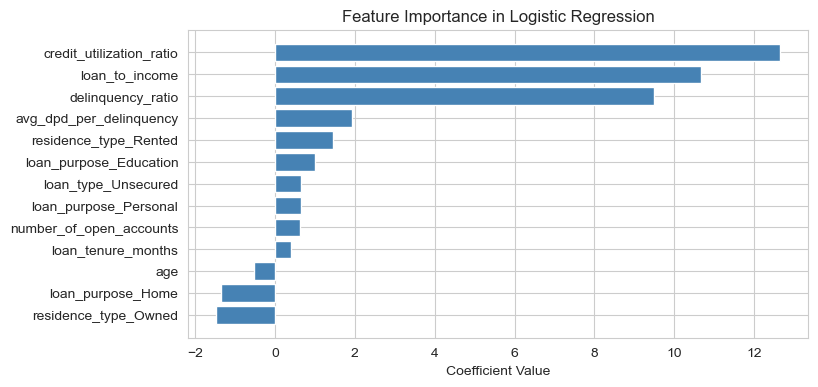

In [84]:
feature_importance = model.coef_[0]

# Create a DataFrame for easier handling
coef_df = pd.DataFrame(feature_importance, index=X_train_encoded.columns, columns=['Coefficients'])

# Sort the coefficients for better visualization
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)

# Plotting
plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Logistic Regression')
plt.show()

In [85]:
from sklearn.ensemble import RandomForestClassifier

In [86]:
model = RandomForestClassifier()
model.fit(X_train_encoded, y_train)

y_pred = model.predict(X_test_encoded)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     11423
           1       0.85      0.71      0.78      1074

    accuracy                           0.96     12497
   macro avg       0.91      0.85      0.88     12497
weighted avg       0.96      0.96      0.96     12497



In [87]:
from xgboost import XGBClassifier

model = XGBClassifier()
model.fit(X_train_encoded, y_train)

y_pred = model.predict(X_test_encoded)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     11423
           1       0.81      0.75      0.78      1074

    accuracy                           0.96     12497
   macro avg       0.89      0.87      0.88     12497
weighted avg       0.96      0.96      0.96     12497



Since there is not much difference between XGB and Logistic, we will choose LogisticRegression as a candidate for our RandomizedSearchCV candidate it has a better interpretation.

#### RandomizedSearch CV for Attempt 1: Logistic Regression

In [88]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'C': np.logspace(-4, 4, 20),  # Logarithmically spaced values from 10^-4 to 10^4
    'solver': ['lbfgs', 'saga', 'liblinear', 'newton-cg']   # Algorithm to use in the optimization problem
}

# Create the Logistic Regression model
log_reg = LogisticRegression(max_iter=10000)  # Increased max_iter for convergence

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=log_reg,
    param_distributions=param_dist,
    n_iter=50,  # Number of parameter settings that are sampled
    scoring='f1',
    cv=3,  # 5-fold cross-validation
    verbose=2,
    random_state=42,  # Set a random state for reproducibility
    n_jobs=-1  # Use all available cores
)

# Fit the RandomizedSearchCV to the training data
random_search.fit(X_train_encoded, y_train)

# Print the best parameters and best score
print(f"Best Parameters: {random_search.best_params_}")
print(f"Best Score: {random_search.best_score_}")

best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test_encoded)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END .............................C=0.0001, solver=lbfgs; total time=   0.1s
[CV] END .............................C=0.0001, solver=lbfgs; total time=   0.1s
[CV] END .............................C=0.0001, solver=lbfgs; total time=   0.1s
[CV] END ...........C=0.012742749857031334, solver=liblinear; total time=   0.2s
[CV] END ............C=0.08858667904100823, solver=liblinear; total time=   0.3s
[CV] END ............C=0.08858667904100823, solver=liblinear; total time=   0.3s
[CV] END ............C=0.08858667904100823, solver=liblinear; total time=   0.3s
[CV] END ...........C=0.012742749857031334, solver=liblinear; total time=   0.2s
[CV] END ................C=0.08858667904100823, solver=lbfgs; total time=   0.2s
[CV] END ..........C=0.0006951927961775605, solver=liblinear; total time=   0.2s
[CV] END ................C=0.08858667904100823, solver=lbfgs; total time=   0.2s
[CV] END ...........C=0.012742749857031334, sol

#### RandomizedSearch CV for Attempt 1: XGBoost

In [89]:
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV

# Define parameter distribution for RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 150, 200, 250, 300],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'scale_pos_weight': [1, 2, 3, 5, 7, 10],
    'reg_alpha': [0.01, 0.1, 0.5, 1.0, 5.0, 10.0],  # L1 regularization term
    'reg_lambda': [0.01, 0.1, 0.5, 1.0, 5.0, 10.0]  # L2 regularization term
}

xgb = XGBClassifier()

random_search = RandomizedSearchCV(estimator=xgb, param_distributions=param_dist, n_iter=100,
                                   scoring='f1', cv=3, verbose=1, n_jobs=-1, random_state=42)

random_search.fit(X_train_encoded, y_train)

# Print the best parameters and best score
print(f"Best Parameters: {random_search.best_params_}")
print(f"Best Score: {random_search.best_score_}")

best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test_encoded)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best Parameters: {'subsample': 0.8, 'scale_pos_weight': 2, 'reg_lambda': 1.0, 'reg_alpha': 5.0, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.2, 'colsample_bytree': 0.9}
Best Score: 0.7892546604391856
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     11423
           1       0.77      0.83      0.80      1074

    accuracy                           0.96     12497
   macro avg       0.88      0.90      0.89     12497
weighted avg       0.97      0.96      0.96     12497



### Attempt 2

1. Logistic Regression & XGB
1. Handle Class Imbalance Using Under Sampling

In [90]:
from imblearn.under_sampling import RandomUnderSampler

rndm_under_samping = RandomUnderSampler(random_state=43)
X_train_rndm, y_train_rndm = rndm_under_samping.fit_resample(X_train_encoded, y_train)
y_train_rndm.value_counts()

default
0    3223
1    3223
Name: count, dtype: int64

##### Logistic Regression with undersampling data

In [91]:
model = LogisticRegression()
model.fit(X_train_rndm, y_train_rndm)

y_pred = model.predict(X_test_encoded)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.91      0.95     11423
           1       0.50      0.96      0.66      1074

    accuracy                           0.91     12497
   macro avg       0.75      0.93      0.80     12497
weighted avg       0.95      0.91      0.93     12497



##### XGBoost with undersampling data

In [92]:
model = XGBClassifier(**random_search.best_params_)
model.fit(X_train_rndm, y_train_rndm)

y_pred = model.predict(X_test_encoded)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.91      0.95     11423
           1       0.50      0.99      0.67      1074

    accuracy                           0.91     12497
   macro avg       0.75      0.95      0.81     12497
weighted avg       0.96      0.91      0.93     12497



### Attempt 3

1. Logistic Regression
1. Handle Class Imbalance Using SMOTE Tomek
1. Parameter tunning using optuna

In [93]:
from imblearn.combine import SMOTETomek

smt = SMOTETomek(random_state=42)
X_train_smt, y_train_smt = smt.fit_resample(X_train_encoded, y_train)
y_train_smt.value_counts()

default
0    34196
1    34196
Name: count, dtype: int64

In [94]:
model = LogisticRegression()
model.fit(X_train_smt, y_train_smt)

y_pred = model.predict(X_test_encoded)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.99      0.93      0.96     11423
           1       0.55      0.94      0.70      1074

    accuracy                           0.93     12497
   macro avg       0.77      0.94      0.83     12497
weighted avg       0.96      0.93      0.94     12497



In [95]:
model = XGBClassifier(**random_search.best_params_)
model.fit(X_train_smt, y_train_smt)

y_pred = model.predict(X_test_encoded)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.93      0.96     11423
           1       0.56      0.97      0.71      1074

    accuracy                           0.93     12497
   macro avg       0.78      0.95      0.83     12497
weighted avg       0.96      0.93      0.94     12497



### Attempt 4

1. Logistic Regression
1. XGBoost
1. Handle Class Imbalance Using SMOTE Tomek
1. Parameter tunning using optuna

In [96]:
import optuna
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import cross_val_score

##### Logistic Regression

In [97]:
# Define the objective function for Optuna
def objective(trial):
    param = {
        'C': trial.suggest_float('C', 1e-4, 1e4, log=True), # Logarithmically spaced values
        'solver': trial.suggest_categorical('solver', ['lbfgs', 'liblinear', 'saga', 'newton-cg']),  # Solvers
        'tol': trial.suggest_float('tol', 1e-6, 1e-1, log=True),  # Logarithmically spaced values for tolerance
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced'])  # Class weights
    }
    model = LogisticRegression(**param, max_iter=10000)

    # Calculate the cross-validated f1_score
    f1_scorer = make_scorer(f1_score, average='macro')
    scores = cross_val_score(model, X_train_smt, y_train_smt, cv=3, scoring=f1_scorer, n_jobs=-1)
    
    return np.mean(scores)

study_logistic = optuna.create_study(direction='maximize')
study_logistic.optimize(objective, n_trials=50)

[I 2025-08-07 00:22:39,867] A new study created in memory with name: no-name-3fee4798-b656-4e72-842f-c741595516de
[I 2025-08-07 00:22:40,180] Trial 0 finished with value: 0.9456949012506062 and parameters: {'C': 10.119374429291335, 'solver': 'newton-cg', 'tol': 6.299992320521876e-05, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.9456949012506062.
[I 2025-08-07 00:22:40,424] Trial 1 finished with value: 0.9446780132809725 and parameters: {'C': 0.3496765596424322, 'solver': 'saga', 'tol': 0.0009787024012426443, 'class_weight': None}. Best is trial 0 with value: 0.9456949012506062.
[I 2025-08-07 00:22:40,710] Trial 2 finished with value: 0.9456223856341882 and parameters: {'C': 60.9515610841878, 'solver': 'saga', 'tol': 0.00018149644172531053, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.9456949012506062.
[I 2025-08-07 00:22:40,890] Trial 3 finished with value: 0.9183236983975362 and parameters: {'C': 0.008200394234488397, 'solver': 'liblinear', 'tol': 0.0064171

In [98]:
print('Best trial:')
trial = study_logistic.best_trial
print('  F1-score: {}'.format(trial.value))
print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))
    
best_model_logistic = LogisticRegression(**study_logistic.best_params)
best_model_logistic.fit(X_train_smt, y_train_smt)

# Evaluate on the test set
y_pred = best_model_logistic.predict(X_test_encoded)

report = classification_report(y_test, y_pred)
print(report)

Best trial:
  F1-score: 0.9458399397443215
  Params: 
    C: 5.655498806144435
    solver: liblinear
    tol: 0.001155406570884697
    class_weight: balanced
              precision    recall  f1-score   support

           0       0.99      0.93      0.96     11423
           1       0.56      0.94      0.70      1074

    accuracy                           0.93     12497
   macro avg       0.78      0.94      0.83     12497
weighted avg       0.96      0.93      0.94     12497



##### XGBClassifier

In [99]:
# Define the objective function for Optuna
def objective(trial):
    param = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'verbosity': 0,
        'booster': 'gbtree',
        'lambda': trial.suggest_float('lambda', 1e-3, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-3, 10.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'gamma': trial.suggest_float('gamma', 0, 10),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'max_delta_step': trial.suggest_int('max_delta_step', 0, 10)
    }

    model = XGBClassifier(**param)
    
    # Calculate the cross-validated f1_score
    f1_scorer = make_scorer(f1_score, average='macro')
    scores = cross_val_score(model, X_train_smt, y_train_smt, cv=3, scoring=f1_scorer, n_jobs=-1)
    
    return np.mean(scores)

study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective, n_trials=50)

[I 2025-08-07 00:22:52,549] A new study created in memory with name: no-name-fea61dff-f9ba-4407-9150-c007402d67c6
[I 2025-08-07 00:22:52,970] Trial 0 finished with value: 0.965347878508143 and parameters: {'lambda': 0.011642673160195077, 'alpha': 0.48172095252859926, 'subsample': 0.8140886384865271, 'colsample_bytree': 0.4497088512501816, 'max_depth': 8, 'eta': 0.2754549995345542, 'gamma': 8.833167782408841, 'scale_pos_weight': 3.245102320935152, 'min_child_weight': 2, 'max_delta_step': 0}. Best is trial 0 with value: 0.965347878508143.
[I 2025-08-07 00:22:53,334] Trial 1 finished with value: 0.9514538008211083 and parameters: {'lambda': 6.284020008903358, 'alpha': 0.04052231181946793, 'subsample': 0.691917450136175, 'colsample_bytree': 0.6590660157044481, 'max_depth': 3, 'eta': 0.09323766344891639, 'gamma': 5.663612218015869, 'scale_pos_weight': 1.519931089505067, 'min_child_weight': 6, 'max_delta_step': 7}. Best is trial 0 with value: 0.965347878508143.
[I 2025-08-07 00:22:53,849] Tr

In [100]:
print('Best trial:')
trial = study_xgb.best_trial
print('  F1-score: {}'.format(trial.value))
print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))
    
best_params = study_xgb.best_params
best_model_xgb = XGBClassifier(**best_params)
best_model_xgb.fit(X_train_smt, y_train_smt)

# Evaluate on the test set
y_pred = best_model_xgb.predict(X_test_encoded)

report = classification_report(y_test, y_pred)
print(report)

Best trial:
  F1-score: 0.9767474961701771
  Params: 
    lambda: 0.005591386147004106
    alpha: 0.04052774907823097
    subsample: 0.7032643514883825
    colsample_bytree: 0.4877230505300717
    max_depth: 10
    eta: 0.21385936389607396
    gamma: 0.13024212593118295
    scale_pos_weight: 1.2946964824448022
    min_child_weight: 4
    max_delta_step: 3
              precision    recall  f1-score   support

           0       0.98      0.97      0.98     11423
           1       0.74      0.84      0.79      1074

    accuracy                           0.96     12497
   macro avg       0.86      0.91      0.88     12497
weighted avg       0.96      0.96      0.96     12497



## Model Evaluation : ROC/AUC

In [101]:
y_pred = best_model_logistic.predict(X_test_encoded)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.99      0.93      0.96     11423
           1       0.56      0.94      0.70      1074

    accuracy                           0.93     12497
   macro avg       0.78      0.94      0.83     12497
weighted avg       0.96      0.93      0.94     12497



In [102]:
from sklearn.metrics import roc_curve

probabilities = best_model_logistic.predict_proba(X_test_encoded)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, probabilities)

fpr[:5], tpr[:5], thresholds[:5]

(array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 8.75426771e-05,
        8.75426771e-05]),
 array([0.        , 0.0009311 , 0.16108007, 0.16108007, 0.17597765]),
 array([       inf, 1.        , 0.99944254, 0.99944045, 0.99932371]))

In [103]:
from sklearn.metrics import auc

area = auc(fpr, tpr)
area

0.9836668513703037

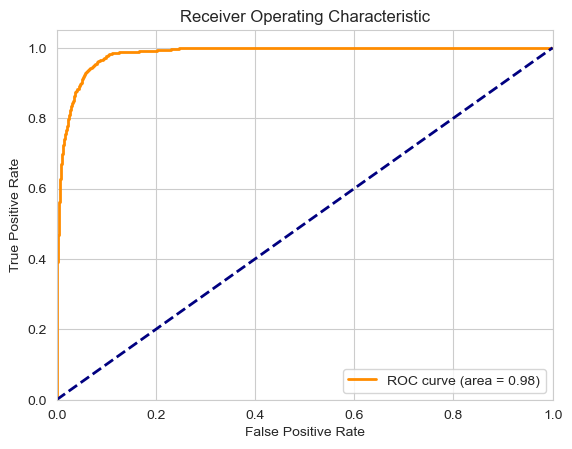

In [104]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % area)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Model Evaluation : Rankordering, KS statistic, Gini coeff

In [105]:
probabilities = best_model_logistic.predict_proba(X_test_encoded)[:,1]
probabilities[:5,]

array([5.33811276e-01, 1.20518861e-05, 5.65828320e-03, 6.45686696e-03,
       9.20391029e-01])

In [106]:
df_eval = pd.DataFrame({
    'Default Truth': y_test,
    'Default Probability': probabilities
})
df_eval.head(3)

,Default Truth,Default Probability
19205,0,0.53
15514,0,0.00
30367,0,0.01


In [107]:
df_eval['Decile'] = pd.qcut(df_eval['Default Probability'], 10, labels=False, duplicates='drop')
df_eval.head(3)

,Default Truth,Default Probability,Decile
19205,0,0.53,8
15514,0,0.00,2
30367,0,0.01,6


In [108]:
df_eval[df_eval.Decile==8]['Default Probability'].describe()

count   1250.00
mean       0.49
std        0.18
min        0.21
25%        0.32
50%        0.47
75%        0.64
max        0.82
Name: Default Probability, dtype: float64

In [109]:
df_decile = df_eval.groupby('Decile').apply(lambda x: pd.Series({
    'Minimum Probability': x['Default Probability'].min(),
    'Maximum Probability': x['Default Probability'].max(),
    'Events': x['Default Truth'].sum(),
    'Non-events': x['Default Truth'].count() - x['Default Truth'].sum(),    
}))
df_decile.reset_index(inplace=True)
df_decile

/var/folders/4j/jmq0hxkx5fgc9tcsxwt2649m0000gn/T/ipykernel_20861/4037021561.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_decile = df_eval.groupby('Decile').apply(lambda x: pd.Series({


,Decile,Minimum Probability,Maximum Probability,Events,Non-events
0,0,0.00,0.00,0.00,1250.00
1,1,0.00,0.00,0.00,1250.00
2,2,0.00,0.00,0.00,1249.00
3,3,0.00,0.00,0.00,1250.00
4,4,0.00,0.00,0.00,1250.00
5,5,0.00,0.00,0.00,1249.00
6,6,0.00,0.03,5.00,1245.00
7,7,0.03,0.21,10.00,1239.00
8,8,0.21,0.82,161.00,1089.00
9,9,0.82,1.00,898.00,352.00


In [110]:
df_decile['Event Rate'] = df_decile['Events']*100 / (df_decile['Events']+df_decile['Non-events'])
df_decile['Non-event Rate'] = df_decile['Non-events']*100 / (df_decile['Events']+df_decile['Non-events'])
df_decile

,Decile,Minimum Probability,Maximum Probability,Events,Non-events,Event Rate,Non-event Rate
0,0,0.00,0.00,0.00,1250.00,0.00,100.00
1,1,0.00,0.00,0.00,1250.00,0.00,100.00
2,2,0.00,0.00,0.00,1249.00,0.00,100.00
3,3,0.00,0.00,0.00,1250.00,0.00,100.00
4,4,0.00,0.00,0.00,1250.00,0.00,100.00
5,5,0.00,0.00,0.00,1249.00,0.00,100.00
6,6,0.00,0.03,5.00,1245.00,0.40,99.60
7,7,0.03,0.21,10.00,1239.00,0.80,99.20
8,8,0.21,0.82,161.00,1089.00,12.88,87.12
9,9,0.82,1.00,898.00,352.00,71.84,28.16


In [111]:
df_decile = df_decile.sort_values(by='Decile', ascending=False).reset_index(drop=True)
df_decile

,Decile,Minimum Probability,Maximum Probability,Events,Non-events,Event Rate,Non-event Rate
0,9,0.82,1.00,898.00,352.00,71.84,28.16
1,8,0.21,0.82,161.00,1089.00,12.88,87.12
2,7,0.03,0.21,10.00,1239.00,0.80,99.20
3,6,0.00,0.03,5.00,1245.00,0.40,99.60
4,5,0.00,0.00,0.00,1249.00,0.00,100.00
5,4,0.00,0.00,0.00,1250.00,0.00,100.00
6,3,0.00,0.00,0.00,1250.00,0.00,100.00
7,2,0.00,0.00,0.00,1249.00,0.00,100.00
8,1,0.00,0.00,0.00,1250.00,0.00,100.00
9,0,0.00,0.00,0.00,1250.00,0.00,100.00


In [112]:
df_decile['Cum Events'] =  df_decile['Events'].cumsum()
df_decile['Cum Non-events'] =  df_decile['Non-events'].cumsum()
df_decile

,Decile,Minimum Probability,Maximum Probability,Events,Non-events,Event Rate,Non-event Rate,Cum Events,Cum Non-events
0,9,0.82,1.00,898.00,352.00,71.84,28.16,898.00,352.00
1,8,0.21,0.82,161.00,1089.00,12.88,87.12,1059.00,1441.00
2,7,0.03,0.21,10.00,1239.00,0.80,99.20,1069.00,2680.00
3,6,0.00,0.03,5.00,1245.00,0.40,99.60,1074.00,3925.00
4,5,0.00,0.00,0.00,1249.00,0.00,100.00,1074.00,5174.00
5,4,0.00,0.00,0.00,1250.00,0.00,100.00,1074.00,6424.00
6,3,0.00,0.00,0.00,1250.00,0.00,100.00,1074.00,7674.00
7,2,0.00,0.00,0.00,1249.00,0.00,100.00,1074.00,8923.00
8,1,0.00,0.00,0.00,1250.00,0.00,100.00,1074.00,10173.00
9,0,0.00,0.00,0.00,1250.00,0.00,100.00,1074.00,11423.00


In [113]:
df_decile['Cum Event Rate'] = df_decile['Cum Events'] * 100 / df_decile['Events'].sum()
df_decile['Cum Non-event Rate'] = df_decile['Cum Non-events']*100 / df_decile['Non-events'].sum()
df_decile

,Decile,Minimum Probability,Maximum Probability,Events,Non-events,Event Rate,Non-event Rate,Cum Events,Cum Non-events,Cum Event Rate,Cum Non-event Rate
0,9,0.82,1.00,898.00,352.00,71.84,28.16,898.00,352.00,83.61,3.08
1,8,0.21,0.82,161.00,1089.00,12.88,87.12,1059.00,1441.00,98.60,12.61
2,7,0.03,0.21,10.00,1239.00,0.80,99.20,1069.00,2680.00,99.53,23.46
3,6,0.00,0.03,5.00,1245.00,0.40,99.60,1074.00,3925.00,100.00,34.36
4,5,0.00,0.00,0.00,1249.00,0.00,100.00,1074.00,5174.00,100.00,45.29
5,4,0.00,0.00,0.00,1250.00,0.00,100.00,1074.00,6424.00,100.00,56.24
6,3,0.00,0.00,0.00,1250.00,0.00,100.00,1074.00,7674.00,100.00,67.18
7,2,0.00,0.00,0.00,1249.00,0.00,100.00,1074.00,8923.00,100.00,78.11
8,1,0.00,0.00,0.00,1250.00,0.00,100.00,1074.00,10173.00,100.00,89.06
9,0,0.00,0.00,0.00,1250.00,0.00,100.00,1074.00,11423.00,100.00,100.00


In [114]:
df_decile['KS'] = abs(df_decile['Cum Event Rate'] - df_decile['Cum Non-event Rate'])
df_decile

,Decile,Minimum Probability,Maximum Probability,Events,Non-events,Event Rate,Non-event Rate,Cum Events,Cum Non-events,Cum Event Rate,Cum Non-event Rate,KS
0,9,0.82,1.00,898.00,352.00,71.84,28.16,898.00,352.00,83.61,3.08,80.53
1,8,0.21,0.82,161.00,1089.00,12.88,87.12,1059.00,1441.00,98.60,12.61,85.99
2,7,0.03,0.21,10.00,1239.00,0.80,99.20,1069.00,2680.00,99.53,23.46,76.07
3,6,0.00,0.03,5.00,1245.00,0.40,99.60,1074.00,3925.00,100.00,34.36,65.64
4,5,0.00,0.00,0.00,1249.00,0.00,100.00,1074.00,5174.00,100.00,45.29,54.71
5,4,0.00,0.00,0.00,1250.00,0.00,100.00,1074.00,6424.00,100.00,56.24,43.76
6,3,0.00,0.00,0.00,1250.00,0.00,100.00,1074.00,7674.00,100.00,67.18,32.82
7,2,0.00,0.00,0.00,1249.00,0.00,100.00,1074.00,8923.00,100.00,78.11,21.89
8,1,0.00,0.00,0.00,1250.00,0.00,100.00,1074.00,10173.00,100.00,89.06,10.94
9,0,0.00,0.00,0.00,1250.00,0.00,100.00,1074.00,11423.00,100.00,100.00,0.00


To assess whether rank ordering is followed, we should look at whether higher deciles (those with higher predicted probabilities) have higher event rates compared to lower deciles. Rank ordering means that as you move from the top decile to the bottom decile, the event rate should generally decrease.

Non-Events - termed as good (customers) who do not default. Events - termed as bad (customers) who default.

Events and Non-Events terms are interchanged based on usecase to usecase.

eg: for marketing usecase, which customer to reach out (who will take loan based on offers) will be events - here it will termed as good, and the customers who will not take loans will be non-events (bad).

**Insights from the Decile Table**

1. Top Deciles

* The first decile (Decile 9) has a high event rate of 72.00% and a non-event rate of 28.00%. This indicates that the model is highly confident in predicting events in this decile.
* The second decile (Decile 8) also shows a significant event rate of 12.72%, with a cumulative event rate reaching 98.6%.

2. Middle Deciles:

* Deciles 7 and 6 show a significant drop in event rates

3. Lower Deciles:

* Deciles 5 to 0 show zero events, with all predictions being non-events. These deciles collectively have a non-event rate of 100%.

4. KS Statistic:

* The KS statistic, which is the maximum difference between cumulative event rates and cumulative non-event rates, is highest at Decile 8 with a value of 85.98%. This suggests that the model performs best at distinguishing between events and non-events up to this decile.

* The KS value gradually decreases in the following deciles, indicating a decrease in model performance for distinguishing between events and non-events.

**KS Value**

The highest KS value is 85.98%, found at Decile 8. This indicates that the model's performance in distinguishing between events and non-events is most significant at this decile. (If KS is in top 3 decile and score above 40, it is considered a good predictive model.)

In [115]:
gini_coefficient = 2 * area - 1

print("AUC:", area)
print("Gini Coefficient:", gini_coefficient)

AUC: 0.9836668513703037
Gini Coefficient: 0.9673337027406075


AUC of 0.98: The model is very good at distinguishing between events and non-events.

Gini coefficient of 0.96: This further confirms that the model is highly effective in its predictions, with almost perfect rank ordering capability.

The Gini coefficient ranges from -1 to 1, where a value closer to 1 signifies a perfect model, 0 indicates a model with no discriminative power, and -1 signifies a perfectly incorrect model.

#### Finalize The Model and Visualize Feature Importance

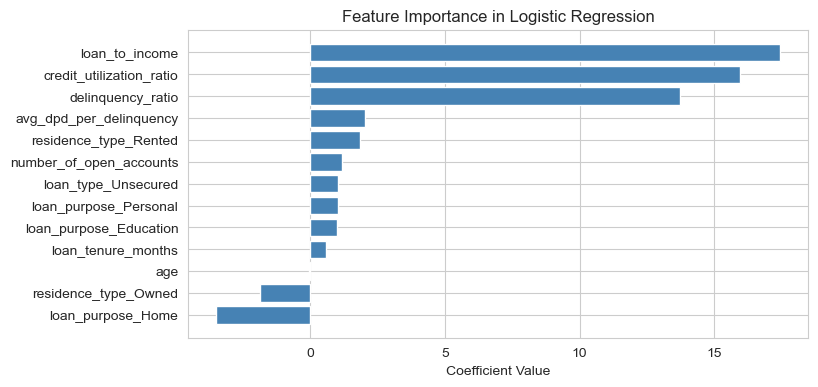

In [116]:
final_model = best_model_logistic

feature_importance = final_model.coef_[0]

# Create a DataFrame for easier handling
coef_df = pd.DataFrame(feature_importance, index=X_train_encoded.columns, columns=['Coefficients'])

# Sort the coefficients for better visualization
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)

# Plotting
plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Logistic Regression')
plt.show()

### Save the Model

In [117]:
X_test_encoded.head(2)

,age,number_of_open_accounts,credit_utilization_ratio,loan_tenure_months,loan_to_income,delinquency_ratio,avg_dpd_per_delinquency,residence_type_Owned,residence_type_Rented,loan_purpose_Education,loan_purpose_Home,loan_purpose_Personal,loan_type_Unsecured
19205,0.35,0.33,0.99,0.75,0.55,0.00,0.00,True,False,False,True,False,False
15514,0.48,1.00,0.32,0.23,0.22,0.00,0.00,True,False,True,False,False,False


In [118]:
X_test_encoded.columns

Index(['age', 'number_of_open_accounts', 'credit_utilization_ratio',
       'loan_tenure_months', 'loan_to_income', 'delinquency_ratio',
       'avg_dpd_per_delinquency', 'residence_type_Owned',
       'residence_type_Rented', 'loan_purpose_Education', 'loan_purpose_Home',
       'loan_purpose_Personal', 'loan_type_Unsecured'],
      dtype='object')

In [119]:
cols_to_scale

Index(['age', 'number_of_dependants', 'years_at_current_address',
       'number_of_open_accounts', 'number_of_closed_accounts', 'enquiry_count',
       'credit_utilization_ratio', 'processing_fee', 'gst', 'net_disbursement',
       'loan_tenure_months', 'principal_outstanding',
       'bank_balance_at_application', 'loan_to_income', 'delinquency_ratio',
       'avg_dpd_per_delinquency'],
      dtype='object')

In [120]:
from joblib import dump

model_data = {
    'model': final_model,
    'features': X_train_encoded.columns,
    'scaler': scaler,
    'cols_to_scale': cols_to_scale
}
dump(model_data, 'artifacts/model_data.joblib')

['artifacts/model_data.joblib']

In [121]:
final_model.coef_, final_model.intercept_

(array([[-0.029854  ,  1.18434206, 15.9391737 ,  0.59408405, 17.43814742,
         13.74101233,  2.03407616, -1.84659575,  1.84532785,  0.99658952,
         -3.47708773,  1.05084474,  1.05084474]]),
 array([-20.77517356]))

## Attempt 1 - Bayesian Search with logistic regression

In [122]:
from bayes_opt import BayesianOptimization

In [123]:
# Define the function to optimize
def optimize_log_reg(C, max_iter):
    model = LogisticRegression(C=C, max_iter=int(max_iter), solver='liblinear')
    # Perform 5-fold cross-validation
    scores = cross_val_score(model, X_train_encoded, y_train, cv=5, scoring='roc_auc')
    # We want to maximize the AUC-ROC score
    return scores.mean()

In [124]:
# Define the parameter space
param_bounds = {
    'C': (0.001, 10.0),
    'max_iter': (50, 500)
}

In [125]:
# Initialize the Bayesian optimizer
optimizer = BayesianOptimization(
    f=optimize_log_reg,
    pbounds=param_bounds,
    random_state=42
)

In [126]:
# Perform the optimization
optimizer.maximize(init_points=10, n_iter=50)

|   iter    |  target   |     C     | max_iter  |
-------------------------------------------------
| 1         | 0.9826544 | 3.7460266 | 477.82143 |
| 2         | 0.9826857 | 7.3202074 | 319.39631 |
| 3         | 0.9825056 | 1.5610303 | 120.19753 |
| 4         | 0.9819357 | 0.5817780 | 439.77926 |
| 5         | 0.9826784 | 6.0115490 | 368.63266 |
| 6         | 0.9804046 | 0.2068243 | 486.45943 |
| 7         | 0.9826884 | 8.3245939 | 145.55259 |
| 8         | 0.9825486 | 1.8190678 | 132.53202 |
| 9         | 0.9826302 | 3.0431181 | 286.14039 |
| 10        | 0.9826643 | 4.3200182 | 181.05311 |
| 11        | 0.9826869 | 7.8519744 | 118.46654 |
| 12        | 0.9826884 | 9.9913716 | 144.91808 |
| 13        | 0.9826809 | 6.5510892 | 471.05374 |
| 14        | 0.9826650 | 4.4255519 | 310.31656 |
| 15        | 0.9826639 | 4.0940638 | 298.40183 |
| 16        | 0.9826881 | 9.9417871 | 109.00352 |
| 17        | 0.9813706 | 0.3565494 | 106.58386 |
| 18        | 0.9826885 | 9.9035271 | 291.36659 |


In [127]:
# Extract the best parameters
best_params = optimizer.max['params']
best_params['max_iter'] = int(best_params['max_iter'])

In [128]:
# Train the final model with the best parameters
final_model = LogisticRegression(**best_params, solver='liblinear')
final_model.fit(X_train_encoded, y_train)

LogisticRegression(C=9.321097263437172, max_iter=284, solver='liblinear')

In [129]:
# Evaluate the final model on the test set
y_pred = final_model.predict(X_test_encoded)
y_prob = final_model.predict_proba(X_test_encoded)[:, 1]

In [130]:
# Print the classification report and AUC-ROC score
from sklearn.metrics import classification_report, roc_auc_score

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     11423
           1       0.84      0.74      0.78      1074

    accuracy                           0.96     12497
   macro avg       0.91      0.86      0.88     12497
weighted avg       0.96      0.96      0.96     12497



In [131]:
print("AUC-ROC Score:", roc_auc_score(y_test, y_pred))

AUC-ROC Score: 0.8614212056403568


## Attempt 2 - XGBoost with grid search

In [132]:
from sklearn.model_selection import GridSearchCV

In [133]:
# Define the parameter grid for XGBoost
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 200],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1
)

In [134]:
# Fit GridSearchCV
grid_search.fit(X_train_encoded, y_train)

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:23:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:23:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:23:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:23:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraint...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 0.9, 1.0],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 4, 5], 'n_estimators': [50, 100, 200],
                         'subsample': [0.8, 0.9, 1.0]},
             scoring='roc_auc')

In [135]:
# Extract the best parameters
best_params = grid_search.best_params_
best_params

{'colsample_bytree': 0.8,
 'learning_rate': 0.1,
 'max_depth': 3,
 'n_estimators': 200,
 'subsample': 0.9}

In [136]:
# Train the final model with the best parameters
best_xgb_model = grid_search.best_estimator_
y_pred = best_xgb_model.predict(X_test_encoded)
y_prob = best_xgb_model.predict_proba(X_test_encoded)[:, 1]

In [137]:
# Evaluate the final model
roc_auc = roc_auc_score(y_test, y_prob)
roc_auc

0.988691100039761

In [138]:
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98     11423
           1       0.85      0.75      0.80      1074

    accuracy                           0.97     12497
   macro avg       0.92      0.87      0.89     12497
weighted avg       0.97      0.97      0.97     12497



In [139]:
import shap
# Create a SHAP explainer
explainer = shap.TreeExplainer(best_xgb_model)
shap_values = explainer.shap_values(X_test_encoded)

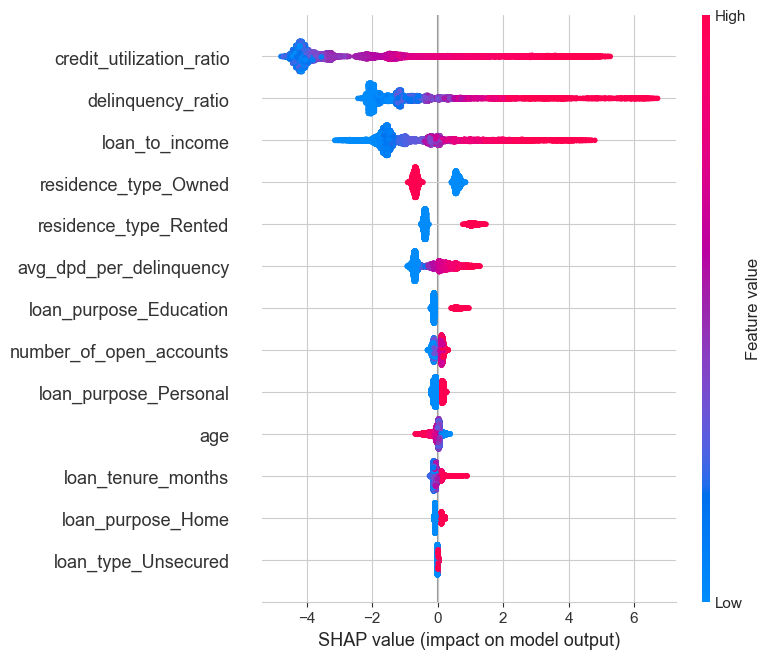

In [140]:
# Summary plot
shap.summary_plot(shap_values, X_test_encoded)

1. credit_utilization_ratio: High values (red) increase the likelihood of default, as shown by positive SHAP values.
2. delinquency_ratio: Similarly, higher values increase the risk, shown by positive SHAP values.
3. loan_to_income: Higher values (red) also increase the default risk.
4. residence_type_Owned and residence_type_Rented: Different impacts based on whether the residence is owned or rented.
5. avg_dpd_per_delinquency: Higher average days past due per delinquency increase the risk.

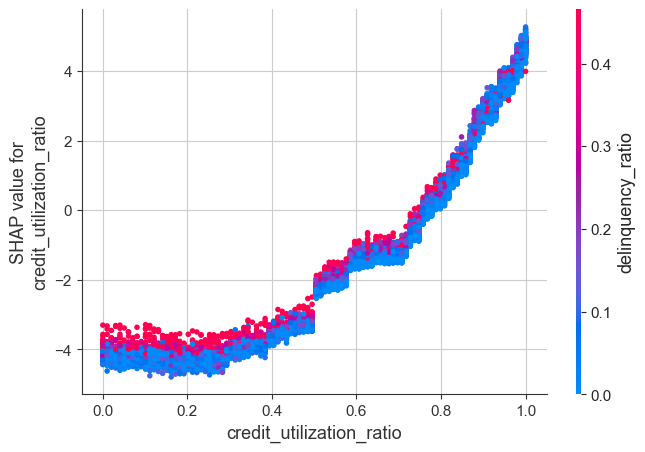

In [141]:
# Dependence plot for a specific feature
shap.dependence_plot("credit_utilization_ratio", shap_values, X_test_encoded)

In [142]:
# plot for a single prediction
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test_encoded.iloc[0,:])